# Generating Painted Fantasy Portraits using Adversarial CNNs
The video game Pillars of Eternity 2: Deadfire allows the player to import custom portraits for the player character. However, in addition to a regular portrait, the game requires a "painted", smaller version that is used in game dialogue and storytelling scenes. 

Creating these painted versions is usually done manually using a photo editing tool, but in theory the process could be automated with the help of machine learning.

Generative Adversarial Networks allow the creation of images like other images by linking two networks. The discriminator learns to distinguish generated images from authentic ones, and the generator learns to fool the discriminator by generating better and better looking images.

This architecture is complex and learning it fully will take time. For now, we will implement a pre created code base and work around it.

Sources: https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/
## Reading Images

In [17]:
from os import listdir

path = 'data/'
image_list = listdir(path)
portrait_list = [file for file in image_list if file.endswith('lg.png')]
painting_list = [file for file in image_list if file.endswith('convo.png')]

### Quick Visualization

(330, 0)

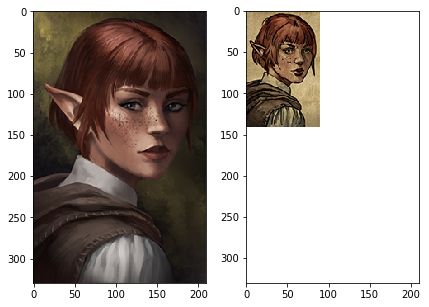

In [18]:
import matplotlib.pyplot as plt
img_number = 12
portrait = plt.imread('data\\'+portrait_list[img_number])
painting = plt.imread('data\\'+painting_list[img_number])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,5))
ax1.imshow(portrait)
ax2.imshow(painting)
ax2.set_xlim([0,portrait.shape[1]])
ax2.set_ylim([portrait.shape[0],0])

## Loading entire dataset and resizing
* We don't need all the information contained in the full 330x210 picture since our objective is only the 141x90 painting.
* We need a nice square format to fit in with the complex algebra of convolution layers
* The architecture we are chosing is designed for 256x256
* We will resize to this format
* In the future, modifying the GAN to work with 128x128 might be beneficial to training time if desired

In [19]:
import os
# required to use AMD GPU with keras via plaidml
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.preprocessing.image import img_to_array, load_img

# reads and resizes dataset
def load_images(filename_list, size):
    output = []
    for filename in filename_list:
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        output.append(pixels)
    return asarray(output)

size = (256, 256)
src_images = load_images(portrait_list, size)
tar_images = load_images(painting_list, size)

print(src_images.shape)
print(tar_images.shape)

(131, 256, 256, 3)
(131, 256, 256, 3)


## Visualizing resized image sample

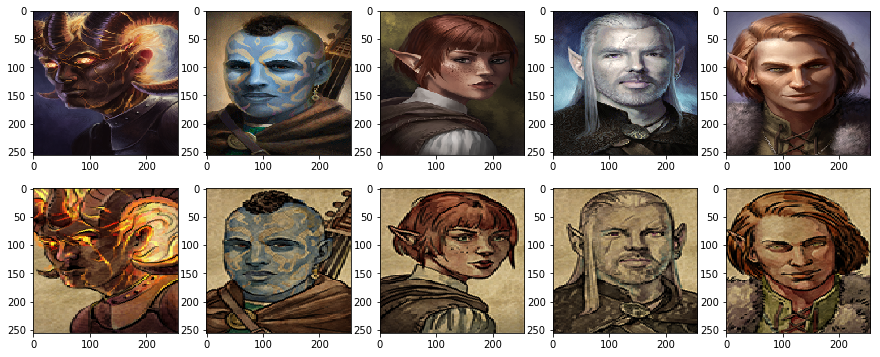

In [21]:
import random

n_samples = 5
plt.figure(figsize=(15,6))

for i in range(n_samples):
    plt.subplot(2, n_samples, 1 + i)
    img_number = random.randint(0,131)
    plt.imshow(src_images[img_number].astype('uint8'))
    plt.subplot(2, n_samples, 1 + n_samples + i)
    plt.imshow(tar_images[img_number].astype('uint8'))

## Saving data to compressed numpy array

In [97]:
from numpy import savez_compressed
filename = 'portrait.npz'
savez_compressed(filename, src_images, tar_images)

## Creating GAN
The implementation is bade on code obtained here: https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/

In [2]:
# example of pix2pix gan for satellite to map image-to-image translation
import os
# required to use AMD GPU with keras via plaidml
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_src_image = Input(shape=image_shape)
	# target image input
	in_target_image = Input(shape=image_shape)
	# concatenate images channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

# define an encoder block
def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def define_generator(image_shape=(256,256,3)):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# encoder model
	e1 = define_encoder_block(in_image, 64, batchnorm=False)
	e2 = define_encoder_block(e1, 128)
	e3 = define_encoder_block(e2, 256)
	e4 = define_encoder_block(e3, 512)
	e5 = define_encoder_block(e4, 512)
	e6 = define_encoder_block(e5, 512)
	e7 = define_encoder_block(e6, 512)
	# bottleneck, no batch norm and relu
	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
	b = Activation('relu')(b)
	# decoder model
	d1 = decoder_block(b, e7, 512)
	d2 = decoder_block(d1, e6, 512)
	d3 = decoder_block(d2, e5, 512)
	d4 = decoder_block(d3, e4, 512, dropout=False)
	d5 = decoder_block(d4, e3, 256, dropout=False)
	d6 = decoder_block(d5, e2, 128, dropout=False)
	d7 = decoder_block(d6, e1, 64, dropout=False)
	# output
	g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# define the source image
	in_src = Input(shape=image_shape)
	# connect the source image to the generator input
	gen_out = g_model(in_src)
	# connect the source input and generator output to the discriminator input
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and classification output
	model = Model(in_src, [dis_out, gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
	return model

# load and prepare training images
def load_real_samples(filename):
	# load compressed arrays
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

# generate samples and save as a plot and save the model
def summarize_performance(step, g_model, dataset, n_samples=3):
	# select a sample of input images
	[X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
	# generate a batch of fake samples
	X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
	# scale all pixels from [-1,1] to [0,1]
	X_realA = (X_realA + 1) / 2.0
	X_realB = (X_realB + 1) / 2.0
	X_fakeB = (X_fakeB + 1) / 2.0
	# plot real source images
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realA[i])
	# plot generated target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples + i)
		pyplot.axis('off')
		pyplot.imshow(X_fakeB[i])
	# plot real target image
	for i in range(n_samples):
		pyplot.subplot(3, n_samples, 1 + n_samples*2 + i)
		pyplot.axis('off')
		pyplot.imshow(X_realB[i])
	# save plot to file
	filename1 = 'plot_%06d.png' % (step+1)
	pyplot.savefig('generated\\'+filename1)
	pyplot.close()
	# save the generator model
	filename2 = 'model_%06d.h5' % (step+1)
	g_model.save('trained_models\\'+filename2)
	print('>Saved: %s and %s' % (filename1, filename2))

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	print('n steps', n_steps)
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples
		[X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
		# generate a batch of fake samples
		X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		# update discriminator for real samples
		d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
		# update discriminator for generated samples
		d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
		# update the generator
		g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])
		# summarize performance
		print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
		# summarize model performance
		if (i+1) % (bat_per_epo * 10) == 0:
			summarize_performance(i, g_model, dataset)

# load image data
dataset = load_real_samples('portrait.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# define the models
d_model = define_discriminator(image_shape)
g_model = define_generator(image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, image_shape)

Using plaidml.keras.backend backend.


Loaded (131, 256, 256, 3) (131, 256, 256, 3)


INFO:plaidml:Opening device "opencl_amd_tonga.0"


## Training the GAN

In [7]:
import time
start_time = time.time()
# train model
train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1)

time_taken = time.time()-start_time


n steps 13100
>1, d1[0.068] d2[0.054] g[31.900]
>2, d1[0.191] d2[0.047] g[28.571]
>3, d1[0.407] d2[1.139] g[23.479]
>4, d1[0.563] d2[0.216] g[31.318]
>5, d1[0.338] d2[0.500] g[27.018]
>6, d1[0.174] d2[0.118] g[25.027]
>7, d1[0.151] d2[0.178] g[24.355]
>8, d1[0.313] d2[0.090] g[27.484]
>9, d1[0.101] d2[0.077] g[26.728]
>10, d1[0.010] d2[0.404] g[33.394]
>11, d1[0.280] d2[0.051] g[23.059]
>12, d1[0.076] d2[0.060] g[27.027]
>13, d1[0.094] d2[0.130] g[25.023]
>14, d1[0.037] d2[0.037] g[28.003]
>15, d1[0.082] d2[0.068] g[24.092]
>16, d1[0.049] d2[0.109] g[23.827]
>17, d1[0.037] d2[0.084] g[26.775]
>18, d1[0.147] d2[0.090] g[22.894]
>19, d1[0.090] d2[0.191] g[26.532]
>20, d1[0.048] d2[0.088] g[26.642]
>21, d1[0.413] d2[0.129] g[26.241]
>22, d1[0.033] d2[0.117] g[28.165]
>23, d1[0.136] d2[0.079] g[30.103]
>24, d1[0.018] d2[0.096] g[24.606]
>25, d1[0.221] d2[0.111] g[23.921]
>26, d1[0.183] d2[0.091] g[23.547]
>27, d1[0.032] d2[0.065] g[26.239]
>28, d1[0.020] d2[0.123] g[27.666]
>29, d1[0.181] 

>232, d1[0.058] d2[0.037] g[22.852]
>233, d1[0.018] d2[0.024] g[25.211]
>234, d1[0.006] d2[0.219] g[27.867]
>235, d1[0.071] d2[0.003] g[30.637]
>236, d1[0.279] d2[0.008] g[24.555]
>237, d1[0.154] d2[0.292] g[25.721]
>238, d1[0.005] d2[0.011] g[27.455]
>239, d1[0.014] d2[0.008] g[26.195]
>240, d1[0.098] d2[0.022] g[26.456]
>241, d1[0.002] d2[0.118] g[24.347]
>242, d1[0.007] d2[0.014] g[25.150]
>243, d1[0.015] d2[0.008] g[28.634]
>244, d1[0.006] d2[0.016] g[31.942]
>245, d1[0.015] d2[0.029] g[23.636]
>246, d1[0.019] d2[0.046] g[24.278]
>247, d1[0.014] d2[0.252] g[31.684]
>248, d1[0.831] d2[0.142] g[32.818]
>249, d1[0.133] d2[0.034] g[27.250]
>250, d1[0.001] d2[1.580] g[30.739]
>251, d1[0.029] d2[0.005] g[26.469]
>252, d1[0.298] d2[0.028] g[23.898]
>253, d1[0.079] d2[0.126] g[26.361]
>254, d1[0.118] d2[0.277] g[23.740]
>255, d1[0.130] d2[0.126] g[30.447]
>256, d1[0.043] d2[0.019] g[26.723]
>257, d1[0.447] d2[0.182] g[22.611]
>258, d1[0.007] d2[0.122] g[32.262]
>259, d1[0.015] d2[0.093] g[

>460, d1[0.008] d2[0.084] g[32.414]
>461, d1[0.111] d2[0.049] g[26.590]
>462, d1[0.019] d2[0.011] g[27.560]
>463, d1[0.076] d2[0.031] g[24.117]
>464, d1[0.003] d2[0.058] g[26.202]
>465, d1[0.004] d2[0.010] g[30.497]
>466, d1[0.029] d2[0.016] g[24.934]
>467, d1[0.163] d2[0.172] g[26.911]
>468, d1[0.078] d2[0.002] g[33.199]
>469, d1[0.013] d2[0.005] g[30.948]
>470, d1[0.007] d2[0.029] g[26.998]
>471, d1[0.033] d2[0.015] g[30.185]
>472, d1[0.046] d2[0.040] g[25.816]
>473, d1[0.005] d2[0.053] g[28.102]
>474, d1[0.007] d2[0.040] g[30.546]
>475, d1[0.021] d2[0.015] g[27.619]
>476, d1[0.013] d2[0.090] g[24.834]
>477, d1[0.031] d2[0.005] g[28.784]
>478, d1[0.076] d2[0.021] g[24.861]
>479, d1[0.010] d2[0.064] g[26.665]
>480, d1[0.025] d2[0.009] g[25.641]
>481, d1[0.020] d2[0.031] g[23.903]
>482, d1[0.102] d2[0.144] g[25.973]
>483, d1[0.027] d2[0.008] g[28.433]
>484, d1[0.482] d2[0.133] g[26.722]
>485, d1[0.002] d2[0.101] g[26.771]
>486, d1[0.002] d2[0.005] g[34.494]
>487, d1[0.030] d2[0.007] g[

>688, d1[0.009] d2[0.078] g[23.705]
>689, d1[0.011] d2[0.033] g[26.432]
>690, d1[0.052] d2[0.065] g[29.400]
>691, d1[0.005] d2[0.013] g[24.388]
>692, d1[0.048] d2[0.061] g[22.670]
>693, d1[0.016] d2[0.016] g[24.229]
>694, d1[0.026] d2[0.032] g[22.803]
>695, d1[0.070] d2[0.017] g[25.657]
>696, d1[0.007] d2[0.029] g[24.297]
>697, d1[0.009] d2[0.057] g[25.303]
>698, d1[0.274] d2[0.597] g[29.219]
>699, d1[0.678] d2[0.025] g[22.043]
>700, d1[0.003] d2[0.137] g[25.436]
>701, d1[0.003] d2[0.008] g[25.220]
>702, d1[0.012] d2[0.015] g[28.329]
>703, d1[0.003] d2[0.065] g[25.931]
>704, d1[0.007] d2[0.104] g[30.561]
>705, d1[0.595] d2[0.686] g[29.875]
>706, d1[0.204] d2[0.010] g[28.010]
>707, d1[0.100] d2[0.006] g[31.739]
>708, d1[0.004] d2[0.041] g[24.338]
>709, d1[0.007] d2[0.106] g[23.746]
>710, d1[0.007] d2[0.013] g[27.455]
>711, d1[0.029] d2[0.134] g[25.357]
>712, d1[0.040] d2[0.006] g[30.327]
>713, d1[0.221] d2[0.018] g[20.483]
>714, d1[0.005] d2[0.283] g[25.134]
>715, d1[0.022] d2[0.004] g[

>916, d1[0.062] d2[0.034] g[26.503]
>917, d1[0.028] d2[0.016] g[23.646]
>918, d1[0.102] d2[0.149] g[25.550]
>919, d1[0.004] d2[0.010] g[30.293]
>920, d1[0.081] d2[0.009] g[24.146]
>921, d1[0.056] d2[0.012] g[22.563]
>922, d1[0.003] d2[0.137] g[23.014]
>923, d1[0.008] d2[0.012] g[28.202]
>924, d1[0.058] d2[0.018] g[20.300]
>925, d1[0.014] d2[0.013] g[25.236]
>926, d1[0.003] d2[0.050] g[26.252]
>927, d1[0.165] d2[0.145] g[24.326]
>928, d1[0.003] d2[0.058] g[29.713]
>929, d1[0.095] d2[0.024] g[27.006]
>930, d1[0.046] d2[0.485] g[28.464]
>931, d1[0.159] d2[0.001] g[28.771]
>932, d1[0.267] d2[0.003] g[24.949]
>933, d1[0.004] d2[0.014] g[23.575]
>934, d1[0.017] d2[0.033] g[22.890]
>935, d1[0.001] d2[0.107] g[26.474]
>936, d1[0.022] d2[0.113] g[24.029]
>937, d1[0.189] d2[0.094] g[26.747]
>938, d1[0.016] d2[0.244] g[25.893]
>939, d1[0.145] d2[0.004] g[27.863]
>940, d1[0.111] d2[0.053] g[23.151]
>941, d1[0.062] d2[0.309] g[28.836]
>942, d1[0.020] d2[0.001] g[33.063]
>943, d1[1.265] d2[0.581] g[

>1140, d1[0.045] d2[0.001] g[29.491]
>1141, d1[1.055] d2[0.040] g[20.586]
>1142, d1[0.015] d2[0.373] g[27.474]
>1143, d1[0.028] d2[0.184] g[26.296]
>1144, d1[1.522] d2[0.948] g[25.659]
>1145, d1[0.267] d2[0.072] g[22.049]
>1146, d1[0.060] d2[0.068] g[22.119]
>1147, d1[0.042] d2[0.135] g[20.851]
>1148, d1[0.417] d2[0.579] g[24.110]
>1149, d1[0.020] d2[0.045] g[24.916]
>1150, d1[0.487] d2[0.047] g[22.540]
>1151, d1[0.018] d2[0.530] g[28.678]
>1152, d1[0.196] d2[0.026] g[28.651]
>1153, d1[0.458] d2[0.710] g[25.506]
>1154, d1[0.293] d2[0.037] g[23.910]
>1155, d1[0.009] d2[0.268] g[25.798]
>1156, d1[0.820] d2[0.545] g[27.456]
>1157, d1[0.783] d2[0.040] g[19.520]
>1158, d1[0.007] d2[0.233] g[21.591]
>1159, d1[0.026] d2[0.038] g[25.297]
>1160, d1[0.011] d2[0.091] g[21.982]
>1161, d1[0.184] d2[0.424] g[24.252]
>1162, d1[1.048] d2[0.336] g[19.805]
>1163, d1[0.081] d2[0.299] g[24.074]
>1164, d1[0.122] d2[0.028] g[34.031]
>1165, d1[0.056] d2[0.220] g[27.815]
>1166, d1[0.153] d2[0.030] g[26.727]
>

INFO:plaidml:Analyzing Ops: 192 of 301 operations complete
INFO:plaidml:Analyzing Ops: 257 of 301 operations complete


>Saved: plot_001310.png and model_001310.h5
>1311, d1[0.783] d2[0.023] g[25.661]
>1312, d1[0.053] d2[0.304] g[24.368]
>1313, d1[0.759] d2[0.924] g[23.563]
>1314, d1[0.107] d2[0.023] g[29.049]
>1315, d1[0.643] d2[0.298] g[20.728]
>1316, d1[0.033] d2[0.142] g[20.527]
>1317, d1[0.148] d2[0.077] g[22.968]
>1318, d1[0.101] d2[0.174] g[23.248]
>1319, d1[0.032] d2[0.064] g[21.137]
>1320, d1[0.014] d2[0.090] g[27.334]
>1321, d1[0.046] d2[0.060] g[29.999]
>1322, d1[0.328] d2[0.842] g[28.991]
>1323, d1[0.288] d2[0.006] g[30.456]
>1324, d1[0.415] d2[0.152] g[20.378]
>1325, d1[0.053] d2[0.100] g[22.074]
>1326, d1[0.009] d2[0.294] g[24.462]
>1327, d1[0.148] d2[0.025] g[23.605]
>1328, d1[0.294] d2[0.168] g[20.135]
>1329, d1[0.122] d2[0.177] g[24.140]
>1330, d1[0.200] d2[0.165] g[29.722]
>1331, d1[0.021] d2[0.241] g[21.563]
>1332, d1[0.458] d2[0.040] g[24.279]
>1333, d1[0.328] d2[1.044] g[37.742]
>1334, d1[0.061] d2[0.001] g[30.500]
>1335, d1[0.421] d2[0.009] g[27.996]
>1336, d1[0.028] d2[0.053] g[23

>1532, d1[0.048] d2[0.074] g[21.636]
>1533, d1[0.279] d2[0.234] g[21.547]
>1534, d1[0.023] d2[0.210] g[23.878]
>1535, d1[0.018] d2[0.049] g[23.208]
>1536, d1[0.351] d2[0.184] g[22.719]
>1537, d1[0.077] d2[0.058] g[20.277]
>1538, d1[0.079] d2[0.160] g[23.334]
>1539, d1[0.142] d2[0.432] g[23.739]
>1540, d1[0.246] d2[0.011] g[21.562]
>1541, d1[0.129] d2[0.042] g[20.923]
>1542, d1[0.008] d2[0.376] g[25.388]
>1543, d1[0.296] d2[0.045] g[22.607]
>1544, d1[0.103] d2[0.113] g[21.534]
>1545, d1[0.022] d2[0.106] g[26.670]
>1546, d1[0.129] d2[0.030] g[27.727]
>1547, d1[0.203] d2[0.222] g[21.726]
>1548, d1[0.007] d2[0.029] g[24.328]
>1549, d1[0.157] d2[0.048] g[23.107]
>1550, d1[0.008] d2[0.433] g[22.340]
>1551, d1[0.137] d2[0.006] g[24.209]
>1552, d1[1.151] d2[0.115] g[25.885]
>1553, d1[0.101] d2[0.417] g[21.187]
>1554, d1[0.078] d2[0.032] g[21.714]
>1555, d1[0.011] d2[0.100] g[24.924]
>1556, d1[0.146] d2[0.042] g[18.900]
>1557, d1[0.005] d2[0.099] g[28.117]
>1558, d1[0.099] d2[0.309] g[21.877]
>

>1754, d1[0.046] d2[0.012] g[25.876]
>1755, d1[0.473] d2[0.579] g[24.457]
>1756, d1[0.026] d2[0.004] g[26.847]
>1757, d1[0.793] d2[0.069] g[17.515]
>1758, d1[0.009] d2[0.218] g[27.872]
>1759, d1[0.003] d2[0.088] g[25.953]
>1760, d1[0.058] d2[0.226] g[23.107]
>1761, d1[0.224] d2[0.124] g[21.293]
>1762, d1[0.044] d2[0.041] g[25.099]
>1763, d1[0.202] d2[0.405] g[25.092]
>1764, d1[0.452] d2[0.272] g[25.656]
>1765, d1[0.041] d2[0.016] g[24.375]
>1766, d1[0.217] d2[0.025] g[26.241]
>1767, d1[0.016] d2[0.167] g[22.357]
>1768, d1[0.136] d2[0.041] g[21.302]
>1769, d1[0.021] d2[0.247] g[29.031]
>1770, d1[0.017] d2[0.033] g[22.101]
>1771, d1[0.717] d2[0.611] g[22.026]
>1772, d1[0.199] d2[0.020] g[19.820]
>1773, d1[0.405] d2[0.531] g[26.083]
>1774, d1[0.009] d2[0.020] g[20.764]
>1775, d1[0.452] d2[0.163] g[21.010]
>1776, d1[0.005] d2[0.207] g[24.960]
>1777, d1[0.014] d2[0.022] g[23.452]
>1778, d1[0.227] d2[0.149] g[22.430]
>1779, d1[0.297] d2[0.346] g[22.384]
>1780, d1[0.006] d2[0.040] g[30.649]
>

>1976, d1[0.040] d2[0.004] g[24.415]
>1977, d1[0.330] d2[0.035] g[22.850]
>1978, d1[0.023] d2[0.533] g[23.547]
>1979, d1[0.236] d2[0.055] g[19.271]
>1980, d1[0.029] d2[0.021] g[20.522]
>1981, d1[0.010] d2[0.092] g[25.749]
>1982, d1[0.053] d2[0.040] g[23.306]
>1983, d1[0.072] d2[0.124] g[25.110]
>1984, d1[0.367] d2[0.898] g[20.097]
>1985, d1[0.654] d2[0.049] g[20.185]
>1986, d1[0.108] d2[0.117] g[20.215]
>1987, d1[0.021] d2[0.190] g[23.494]
>1988, d1[0.105] d2[0.028] g[21.288]
>1989, d1[0.056] d2[0.261] g[26.878]
>1990, d1[0.831] d2[0.347] g[21.820]
>1991, d1[0.008] d2[0.051] g[20.634]
>1992, d1[0.079] d2[0.040] g[20.875]
>1993, d1[0.376] d2[0.281] g[23.651]
>1994, d1[0.015] d2[0.151] g[21.936]
>1995, d1[0.026] d2[0.030] g[25.567]
>1996, d1[0.462] d2[0.436] g[23.080]
>1997, d1[0.061] d2[0.037] g[20.253]
>1998, d1[0.104] d2[0.070] g[19.015]
>1999, d1[0.070] d2[0.193] g[26.197]
>2000, d1[0.178] d2[0.049] g[22.403]
>2001, d1[0.035] d2[0.106] g[23.631]
>2002, d1[0.043] d2[0.067] g[21.195]
>

>2198, d1[0.044] d2[0.021] g[27.903]
>2199, d1[0.323] d2[0.317] g[21.681]
>2200, d1[0.017] d2[0.034] g[21.226]
>2201, d1[0.421] d2[0.472] g[22.212]
>2202, d1[0.015] d2[0.002] g[24.945]
>2203, d1[0.474] d2[0.035] g[22.464]
>2204, d1[0.006] d2[0.780] g[22.059]
>2205, d1[0.018] d2[0.013] g[23.651]
>2206, d1[1.192] d2[0.750] g[21.927]
>2207, d1[0.120] d2[0.053] g[22.475]
>2208, d1[0.052] d2[0.129] g[23.178]
>2209, d1[0.251] d2[0.278] g[23.003]
>2210, d1[0.109] d2[0.026] g[21.127]
>2211, d1[0.045] d2[0.113] g[20.388]
>2212, d1[0.115] d2[0.078] g[19.379]
>2213, d1[0.058] d2[0.176] g[24.809]
>2214, d1[0.157] d2[0.021] g[25.555]
>2215, d1[0.060] d2[0.104] g[27.261]
>2216, d1[0.226] d2[0.536] g[21.871]
>2217, d1[0.531] d2[0.045] g[20.605]
>2218, d1[0.014] d2[0.275] g[26.497]
>2219, d1[0.315] d2[0.059] g[20.696]
>2220, d1[0.039] d2[0.254] g[20.749]
>2221, d1[0.078] d2[0.093] g[21.548]
>2222, d1[0.364] d2[0.061] g[21.983]
>2223, d1[0.026] d2[0.129] g[20.321]
>2224, d1[0.058] d2[0.195] g[23.641]
>

>2420, d1[0.100] d2[0.175] g[19.851]
>2421, d1[0.143] d2[0.004] g[25.989]
>2422, d1[0.043] d2[0.469] g[28.115]
>2423, d1[0.851] d2[0.442] g[22.860]
>2424, d1[0.021] d2[0.006] g[21.332]
>2425, d1[0.019] d2[0.038] g[20.658]
>2426, d1[0.156] d2[0.796] g[25.439]
>2427, d1[1.414] d2[0.444] g[24.875]
>2428, d1[0.225] d2[0.007] g[19.338]
>2429, d1[0.015] d2[0.054] g[20.370]
>2430, d1[0.026] d2[0.083] g[20.854]
>2431, d1[0.323] d2[0.371] g[25.186]
>2432, d1[0.012] d2[0.038] g[21.578]
>2433, d1[0.280] d2[0.152] g[23.055]
>2434, d1[0.017] d2[0.153] g[19.709]
>2435, d1[0.112] d2[0.037] g[20.621]
>2436, d1[0.072] d2[0.734] g[22.655]
>2437, d1[1.753] d2[0.054] g[19.167]
>2438, d1[0.053] d2[0.188] g[23.704]
>2439, d1[0.155] d2[0.218] g[21.285]
>2440, d1[0.020] d2[0.004] g[25.576]
>2441, d1[0.033] d2[0.063] g[21.278]
>2442, d1[0.082] d2[0.250] g[24.586]
>2443, d1[1.022] d2[0.294] g[21.372]
>2444, d1[0.036] d2[0.055] g[18.510]
>2445, d1[0.093] d2[0.049] g[21.138]
>2446, d1[0.040] d2[0.308] g[22.695]
>

>2641, d1[0.016] d2[0.024] g[18.803]
>2642, d1[0.094] d2[0.067] g[18.395]
>2643, d1[0.040] d2[0.077] g[18.457]
>2644, d1[0.090] d2[0.045] g[15.933]
>2645, d1[0.010] d2[0.022] g[26.849]
>2646, d1[0.010] d2[0.091] g[22.580]
>2647, d1[0.161] d2[0.016] g[21.536]
>2648, d1[0.048] d2[0.472] g[20.140]
>2649, d1[0.209] d2[0.003] g[23.150]
>2650, d1[0.038] d2[0.010] g[22.498]
>2651, d1[0.027] d2[0.029] g[18.456]
>2652, d1[0.048] d2[0.049] g[18.492]
>2653, d1[0.129] d2[0.157] g[20.723]
>2654, d1[0.016] d2[0.038] g[23.280]
>2655, d1[0.133] d2[0.025] g[20.159]
>2656, d1[0.005] d2[0.082] g[24.007]
>2657, d1[0.030] d2[0.148] g[20.911]
>2658, d1[0.060] d2[0.005] g[24.350]
>2659, d1[0.175] d2[0.179] g[20.475]
>2660, d1[0.537] d2[0.626] g[20.381]
>2661, d1[0.140] d2[0.015] g[19.561]
>2662, d1[0.165] d2[0.131] g[18.566]
>2663, d1[0.018] d2[0.072] g[18.851]
>2664, d1[0.026] d2[0.029] g[23.614]
>2665, d1[0.019] d2[0.032] g[22.232]
>2666, d1[0.108] d2[0.189] g[26.142]
>2667, d1[0.030] d2[0.176] g[24.506]
>

>2863, d1[0.109] d2[0.247] g[20.139]
>2864, d1[0.013] d2[0.074] g[21.785]
>2865, d1[0.050] d2[0.255] g[21.787]
>2866, d1[0.298] d2[0.063] g[17.061]
>2867, d1[0.170] d2[0.063] g[18.606]
>2868, d1[0.199] d2[0.214] g[18.395]
>2869, d1[0.030] d2[0.262] g[16.840]
>2870, d1[0.179] d2[0.021] g[19.468]
>2871, d1[0.130] d2[0.037] g[19.302]
>2872, d1[0.020] d2[0.412] g[22.334]
>2873, d1[0.107] d2[0.026] g[17.490]
>2874, d1[0.594] d2[0.497] g[18.817]
>2875, d1[0.050] d2[0.005] g[23.936]
>2876, d1[0.137] d2[0.017] g[18.872]
>2877, d1[0.025] d2[0.082] g[18.130]
>2878, d1[0.083] d2[0.076] g[16.334]
>2879, d1[0.011] d2[0.144] g[18.923]
>2880, d1[0.050] d2[0.019] g[18.056]
>2881, d1[0.176] d2[0.050] g[17.301]
>2882, d1[0.007] d2[0.189] g[19.077]
>2883, d1[0.056] d2[0.044] g[17.832]
>2884, d1[0.008] d2[0.094] g[18.569]
>2885, d1[0.718] d2[0.080] g[18.350]
>2886, d1[0.035] d2[0.080] g[16.644]
>2887, d1[0.009] d2[0.141] g[19.430]
>2888, d1[0.065] d2[0.044] g[20.029]
>2889, d1[0.035] d2[0.028] g[21.089]
>

>3085, d1[0.062] d2[0.022] g[22.972]
>3086, d1[0.029] d2[0.190] g[20.652]
>3087, d1[0.088] d2[0.042] g[20.831]
>3088, d1[0.133] d2[0.137] g[18.028]
>3089, d1[0.258] d2[0.060] g[19.125]
>3090, d1[0.003] d2[0.118] g[20.271]
>3091, d1[0.022] d2[0.023] g[15.503]
>3092, d1[0.009] d2[0.018] g[21.061]
>3093, d1[0.023] d2[0.047] g[25.365]
>3094, d1[0.013] d2[0.277] g[23.422]
>3095, d1[1.252] d2[0.104] g[16.963]
>3096, d1[0.003] d2[0.269] g[20.288]
>3097, d1[0.104] d2[0.021] g[19.905]
>3098, d1[1.036] d2[0.356] g[16.594]
>3099, d1[0.061] d2[0.036] g[18.605]
>3100, d1[0.019] d2[0.145] g[19.940]
>3101, d1[0.055] d2[0.017] g[20.762]
>3102, d1[0.248] d2[1.207] g[27.285]
>3103, d1[1.059] d2[0.161] g[15.626]
>3104, d1[0.028] d2[0.053] g[19.870]
>3105, d1[0.009] d2[0.198] g[25.197]
>3106, d1[0.101] d2[0.287] g[23.356]
>3107, d1[0.279] d2[0.139] g[19.452]
>3108, d1[0.260] d2[0.089] g[23.418]
>3109, d1[0.011] d2[0.378] g[20.568]
>3110, d1[0.613] d2[0.057] g[14.387]
>3111, d1[0.044] d2[0.039] g[18.150]
>

>3307, d1[0.015] d2[0.245] g[18.347]
>3308, d1[0.018] d2[0.003] g[23.940]
>3309, d1[0.318] d2[0.339] g[18.185]
>3310, d1[0.065] d2[0.034] g[18.109]
>3311, d1[0.051] d2[0.071] g[17.029]
>3312, d1[0.155] d2[0.271] g[21.314]
>3313, d1[0.027] d2[0.016] g[20.953]
>3314, d1[0.729] d2[0.630] g[20.968]
>3315, d1[0.100] d2[0.024] g[17.188]
>3316, d1[0.081] d2[0.116] g[15.603]
>3317, d1[0.069] d2[0.047] g[18.622]
>3318, d1[0.148] d2[0.165] g[16.480]
>3319, d1[0.026] d2[0.165] g[20.519]
>3320, d1[0.261] d2[0.166] g[17.232]
>3321, d1[0.296] d2[0.310] g[21.358]
>3322, d1[0.088] d2[0.010] g[15.597]
>3323, d1[0.183] d2[0.011] g[18.015]
>3324, d1[0.017] d2[0.235] g[19.302]
>3325, d1[0.022] d2[0.090] g[16.559]
>3326, d1[0.073] d2[0.018] g[18.475]
>3327, d1[0.536] d2[0.423] g[19.408]
>3328, d1[0.013] d2[0.034] g[19.154]
>3329, d1[0.211] d2[0.068] g[13.568]
>3330, d1[0.006] d2[0.702] g[23.055]
>3331, d1[0.540] d2[0.023] g[20.284]
>3332, d1[0.120] d2[0.382] g[21.683]
>3333, d1[0.218] d2[0.012] g[21.807]
>

>3529, d1[0.066] d2[0.083] g[18.205]
>3530, d1[0.068] d2[0.040] g[17.247]
>3531, d1[0.012] d2[0.319] g[18.390]
>3532, d1[0.418] d2[0.303] g[17.442]
>3533, d1[0.220] d2[0.077] g[20.867]
>3534, d1[0.197] d2[0.009] g[19.146]
>3535, d1[0.017] d2[0.158] g[17.515]
>3536, d1[0.023] d2[0.014] g[17.237]
>3537, d1[0.144] d2[0.062] g[16.656]
>3538, d1[0.016] d2[0.189] g[18.978]
>3539, d1[0.036] d2[0.041] g[17.158]
>3540, d1[0.054] d2[0.072] g[16.226]
>3541, d1[0.400] d2[0.227] g[14.018]
>3542, d1[0.140] d2[0.041] g[18.376]
>3543, d1[0.007] d2[0.042] g[18.881]
>3544, d1[0.045] d2[0.254] g[18.905]
>3545, d1[0.265] d2[0.018] g[18.596]
>3546, d1[0.016] d2[0.134] g[19.382]
>3547, d1[0.151] d2[0.071] g[16.647]
>3548, d1[0.090] d2[0.150] g[16.364]
>3549, d1[0.011] d2[0.131] g[17.606]
>3550, d1[0.264] d2[0.009] g[18.867]
>3551, d1[0.020] d2[0.501] g[17.156]
>3552, d1[0.446] d2[0.041] g[15.643]
>3553, d1[0.012] d2[0.117] g[19.002]
>3554, d1[0.218] d2[0.233] g[17.383]
>3555, d1[0.017] d2[0.026] g[19.088]
>

>3751, d1[0.061] d2[0.010] g[16.906]
>3752, d1[0.430] d2[0.218] g[14.794]
>3753, d1[0.048] d2[0.074] g[14.434]
>3754, d1[0.044] d2[0.038] g[17.390]
>3755, d1[0.014] d2[0.124] g[18.395]
>3756, d1[0.177] d2[0.123] g[16.533]
>3757, d1[0.148] d2[0.151] g[18.216]
>3758, d1[0.347] d2[0.249] g[16.913]
>3759, d1[0.008] d2[0.062] g[15.548]
>3760, d1[0.404] d2[0.362] g[19.139]
>3761, d1[0.108] d2[0.034] g[17.463]
>3762, d1[0.035] d2[0.106] g[15.986]
>3763, d1[0.030] d2[0.053] g[18.116]
>3764, d1[0.202] d2[0.338] g[18.523]
>3765, d1[0.206] d2[0.007] g[20.389]
>3766, d1[0.281] d2[0.450] g[18.295]
>3767, d1[0.024] d2[0.011] g[23.917]
>3768, d1[0.277] d2[0.288] g[17.087]
>3769, d1[0.078] d2[0.048] g[16.227]
>3770, d1[0.185] d2[0.027] g[15.940]
>3771, d1[0.010] d2[0.493] g[19.577]
>3772, d1[0.234] d2[0.010] g[14.563]
>3773, d1[0.113] d2[0.106] g[16.947]
>3774, d1[0.014] d2[0.370] g[20.210]
>3775, d1[1.029] d2[0.090] g[13.256]
>3776, d1[0.751] d2[1.482] g[16.634]
>3777, d1[0.041] d2[0.017] g[18.191]
>

>3972, d1[0.027] d2[0.228] g[14.745]
>3973, d1[0.690] d2[0.355] g[14.256]
>3974, d1[0.110] d2[0.019] g[19.268]
>3975, d1[0.074] d2[0.188] g[14.657]
>3976, d1[0.143] d2[0.377] g[14.201]
>3977, d1[0.248] d2[0.032] g[15.659]
>3978, d1[0.158] d2[0.066] g[14.373]
>3979, d1[0.031] d2[0.151] g[14.011]
>3980, d1[0.077] d2[0.090] g[13.453]
>3981, d1[0.080] d2[0.018] g[16.750]
>3982, d1[0.261] d2[0.567] g[16.420]
>3983, d1[0.139] d2[0.060] g[17.757]
>3984, d1[0.052] d2[0.060] g[14.459]
>3985, d1[0.074] d2[0.023] g[16.462]
>3986, d1[0.098] d2[0.090] g[15.865]
>3987, d1[0.060] d2[0.026] g[14.957]
>3988, d1[0.038] d2[0.138] g[14.782]
>3989, d1[0.077] d2[0.119] g[12.947]
>3990, d1[0.209] d2[0.136] g[12.131]
>3991, d1[0.097] d2[0.044] g[16.656]
>3992, d1[0.047] d2[0.083] g[14.301]
>3993, d1[0.028] d2[0.033] g[17.728]
>3994, d1[0.171] d2[0.103] g[13.601]
>3995, d1[0.019] d2[0.100] g[15.988]
>3996, d1[0.157] d2[0.008] g[20.182]
>3997, d1[0.035] d2[0.035] g[16.261]
>3998, d1[0.015] d2[0.316] g[16.483]
>

>4194, d1[0.655] d2[0.591] g[15.840]
>4195, d1[0.027] d2[0.008] g[17.091]
>4196, d1[0.368] d2[0.750] g[14.691]
>4197, d1[0.315] d2[0.012] g[16.458]
>4198, d1[0.014] d2[0.432] g[15.326]
>4199, d1[0.678] d2[0.134] g[12.617]
>4200, d1[0.159] d2[0.141] g[16.183]
>4201, d1[0.019] d2[0.737] g[16.046]
>4202, d1[1.137] d2[0.689] g[14.862]
>4203, d1[0.301] d2[0.077] g[16.881]
>4204, d1[0.235] d2[0.605] g[18.154]
>4205, d1[0.074] d2[0.018] g[18.998]
>4206, d1[0.230] d2[0.092] g[16.359]
>4207, d1[0.099] d2[0.374] g[17.553]
>4208, d1[0.526] d2[0.222] g[14.121]
>4209, d1[0.178] d2[0.172] g[14.828]
>4210, d1[0.550] d2[0.628] g[14.548]
>4211, d1[0.161] d2[0.099] g[12.328]
>4212, d1[0.167] d2[0.138] g[13.812]
>4213, d1[0.106] d2[0.050] g[15.917]
>4214, d1[0.014] d2[0.144] g[16.257]
>4215, d1[0.233] d2[0.125] g[13.229]
>4216, d1[0.043] d2[0.046] g[17.727]
>4217, d1[0.021] d2[0.090] g[15.726]
>4218, d1[0.482] d2[0.132] g[17.908]
>4219, d1[0.035] d2[0.337] g[17.166]
>4220, d1[0.010] d2[0.093] g[18.196]
>

>4416, d1[0.013] d2[0.390] g[16.687]
>4417, d1[0.024] d2[0.013] g[15.046]
>4418, d1[0.944] d2[0.832] g[16.980]
>4419, d1[0.039] d2[0.019] g[14.840]
>4420, d1[0.291] d2[0.170] g[14.260]
>4421, d1[0.011] d2[0.145] g[16.730]
>4422, d1[0.150] d2[0.091] g[13.933]
>4423, d1[0.191] d2[0.366] g[14.669]
>4424, d1[0.305] d2[0.031] g[12.530]
>4425, d1[0.011] d2[0.427] g[17.853]
>4426, d1[0.852] d2[0.105] g[14.756]
>4427, d1[0.200] d2[0.108] g[13.136]
>4428, d1[0.004] d2[0.346] g[17.683]
>4429, d1[0.067] d2[0.022] g[15.445]
>4430, d1[0.119] d2[0.122] g[14.304]
>4431, d1[0.358] d2[0.681] g[17.408]
>4432, d1[0.112] d2[0.062] g[13.619]
>4433, d1[0.424] d2[0.251] g[17.300]
>4434, d1[0.065] d2[0.026] g[16.419]
>4435, d1[0.035] d2[0.199] g[15.909]
>4436, d1[0.175] d2[0.065] g[13.557]
>4437, d1[0.204] d2[0.078] g[14.983]
>4438, d1[0.031] d2[0.283] g[14.642]
>4439, d1[0.113] d2[0.038] g[17.053]
>4440, d1[0.392] d2[0.455] g[14.314]
>4441, d1[0.181] d2[0.256] g[15.479]
>4442, d1[0.923] d2[0.226] g[15.450]
>

>4638, d1[0.007] d2[0.762] g[19.990]
>4639, d1[0.511] d2[0.103] g[14.409]
>4640, d1[0.294] d2[0.290] g[13.723]
>4641, d1[0.053] d2[0.067] g[13.389]
>4642, d1[0.279] d2[0.130] g[11.633]
>4643, d1[0.025] d2[0.211] g[15.414]
>4644, d1[0.237] d2[0.171] g[16.019]
>4645, d1[0.350] d2[0.180] g[12.280]
>4646, d1[0.039] d2[0.080] g[16.834]
>4647, d1[0.027] d2[0.588] g[19.312]
>4648, d1[1.250] d2[0.106] g[11.666]
>4649, d1[0.784] d2[0.872] g[15.728]
>4650, d1[0.037] d2[0.027] g[14.285]
>4651, d1[0.003] d2[0.526] g[16.344]
>4652, d1[2.069] d2[0.103] g[11.628]
>4653, d1[0.435] d2[0.281] g[15.864]
>4654, d1[0.009] d2[0.789] g[17.165]
>4655, d1[0.962] d2[0.405] g[12.616]
>4656, d1[0.013] d2[0.311] g[14.159]
>4657, d1[1.378] d2[0.411] g[14.102]
>4658, d1[0.442] d2[0.097] g[14.101]
>4659, d1[0.026] d2[0.568] g[13.748]
>4660, d1[0.121] d2[0.051] g[13.914]
>4661, d1[0.571] d2[0.485] g[12.017]
>4662, d1[0.103] d2[0.177] g[13.206]
>4663, d1[0.454] d2[0.214] g[13.199]
>4664, d1[0.084] d2[0.042] g[12.688]
>

>4860, d1[0.326] d2[0.475] g[14.832]
>4861, d1[0.700] d2[0.315] g[16.202]
>4862, d1[0.023] d2[0.161] g[14.273]
>4863, d1[0.514] d2[0.327] g[14.321]
>4864, d1[0.066] d2[0.100] g[12.798]
>4865, d1[0.288] d2[0.325] g[18.294]
>4866, d1[0.851] d2[0.321] g[14.358]
>4867, d1[0.040] d2[0.081] g[15.860]
>4868, d1[0.701] d2[0.956] g[15.497]
>4869, d1[0.059] d2[0.103] g[19.290]
>4870, d1[0.267] d2[0.258] g[13.760]
>4871, d1[0.195] d2[0.019] g[15.873]
>4872, d1[0.046] d2[0.265] g[15.776]
>4873, d1[0.177] d2[0.083] g[13.936]
>4874, d1[0.074] d2[0.414] g[15.855]
>4875, d1[0.295] d2[0.151] g[14.419]
>4876, d1[0.542] d2[0.209] g[12.571]
>4877, d1[0.079] d2[0.261] g[13.175]
>4878, d1[0.112] d2[0.034] g[17.562]
>4879, d1[0.140] d2[0.121] g[15.337]
>4880, d1[0.088] d2[0.042] g[14.953]
>4881, d1[0.162] d2[0.229] g[13.569]
>4882, d1[0.031] d2[0.097] g[14.941]
>4883, d1[0.035] d2[0.172] g[14.939]
>4884, d1[0.241] d2[0.298] g[14.124]
>4885, d1[1.125] d2[0.182] g[14.028]
>4886, d1[0.016] d2[0.091] g[13.933]
>

>5082, d1[0.130] d2[0.204] g[12.671]
>5083, d1[0.091] d2[0.080] g[11.509]
>5084, d1[0.333] d2[0.136] g[11.749]
>5085, d1[0.103] d2[0.231] g[13.024]
>5086, d1[0.037] d2[0.116] g[17.002]
>5087, d1[0.043] d2[0.036] g[14.280]
>5088, d1[0.196] d2[0.155] g[11.609]
>5089, d1[0.414] d2[0.256] g[14.775]
>5090, d1[0.030] d2[0.025] g[15.820]
>5091, d1[0.128] d2[0.193] g[13.518]
>5092, d1[0.088] d2[0.094] g[14.679]
>5093, d1[0.059] d2[0.006] g[18.527]
>5094, d1[0.247] d2[0.083] g[12.429]
>5095, d1[0.008] d2[0.191] g[14.302]
>5096, d1[0.062] d2[0.049] g[12.817]
>5097, d1[0.213] d2[0.094] g[13.146]
>5098, d1[0.006] d2[0.377] g[14.760]
>5099, d1[0.633] d2[0.393] g[12.340]
>5100, d1[0.132] d2[0.028] g[15.543]
>5101, d1[0.330] d2[0.027] g[14.023]
>5102, d1[0.002] d2[1.320] g[16.252]
>5103, d1[0.246] d2[0.073] g[11.576]
>5104, d1[1.083] d2[0.694] g[12.162]
>5105, d1[0.139] d2[0.049] g[11.761]
>5106, d1[0.240] d2[0.162] g[12.840]
>5107, d1[0.012] d2[0.158] g[16.015]
>5108, d1[0.218] d2[0.129] g[16.090]
>

>5303, d1[0.055] d2[0.191] g[14.119]
>5304, d1[0.034] d2[0.023] g[14.234]
>5305, d1[0.308] d2[0.254] g[11.529]
>5306, d1[0.159] d2[0.051] g[12.779]
>5307, d1[0.014] d2[0.294] g[15.016]
>5308, d1[0.563] d2[0.090] g[11.861]
>5309, d1[0.019] d2[0.405] g[16.692]
>5310, d1[0.545] d2[0.116] g[11.970]
>5311, d1[0.029] d2[0.084] g[14.751]
>5312, d1[0.048] d2[0.250] g[15.683]
>5313, d1[0.289] d2[0.155] g[12.336]
>5314, d1[0.336] d2[0.822] g[15.061]
>5315, d1[0.498] d2[0.413] g[12.825]
>5316, d1[0.766] d2[0.393] g[11.885]
>5317, d1[0.148] d2[0.014] g[16.772]
>5318, d1[0.119] d2[0.109] g[11.932]
>5319, d1[0.075] d2[0.066] g[11.986]
>5320, d1[0.045] d2[0.105] g[14.016]
>5321, d1[0.049] d2[0.049] g[13.678]
>5322, d1[0.019] d2[0.174] g[14.277]
>5323, d1[0.156] d2[0.163] g[11.896]
>5324, d1[0.395] d2[0.210] g[12.489]
>5325, d1[0.092] d2[0.114] g[11.690]
>5326, d1[0.181] d2[0.023] g[14.342]
>5327, d1[0.065] d2[0.170] g[12.455]
>5328, d1[0.016] d2[0.109] g[15.274]
>5329, d1[0.111] d2[0.088] g[13.927]
>

>5525, d1[0.090] d2[0.096] g[14.026]
>5526, d1[0.257] d2[0.377] g[15.513]
>5527, d1[0.205] d2[0.039] g[16.822]
>5528, d1[0.026] d2[0.258] g[13.662]
>5529, d1[0.883] d2[0.978] g[17.065]
>5530, d1[0.881] d2[0.625] g[14.432]
>5531, d1[0.297] d2[0.235] g[17.243]
>5532, d1[0.309] d2[0.747] g[14.700]
>5533, d1[0.762] d2[0.199] g[14.805]
>5534, d1[0.327] d2[0.521] g[14.486]
>5535, d1[0.080] d2[0.015] g[15.277]
>5536, d1[0.379] d2[0.725] g[13.676]
>5537, d1[0.220] d2[0.323] g[15.214]
>5538, d1[0.473] d2[0.131] g[15.786]
>5539, d1[0.352] d2[0.170] g[11.322]
>5540, d1[0.029] d2[0.248] g[13.067]
>5541, d1[0.401] d2[0.163] g[10.828]
>5542, d1[0.049] d2[0.244] g[17.962]
>5543, d1[0.428] d2[0.197] g[12.414]
>5544, d1[0.231] d2[0.027] g[11.736]
>5545, d1[0.025] d2[0.205] g[13.627]
>5546, d1[0.044] d2[0.061] g[14.194]
>5547, d1[0.201] d2[0.419] g[16.160]
>5548, d1[0.356] d2[0.130] g[12.159]
>5549, d1[0.150] d2[0.125] g[12.558]
>5550, d1[0.039] d2[0.187] g[16.096]
>5551, d1[0.090] d2[0.122] g[13.211]
>

>5747, d1[0.623] d2[0.138] g[10.720]
>5748, d1[0.004] d2[0.048] g[14.670]
>5749, d1[0.012] d2[0.208] g[13.474]
>5750, d1[0.041] d2[0.028] g[14.533]
>5751, d1[0.114] d2[0.065] g[15.027]
>5752, d1[0.041] d2[0.112] g[11.961]
>5753, d1[0.576] d2[0.373] g[10.871]
>5754, d1[0.107] d2[0.071] g[11.589]
>5755, d1[0.057] d2[0.022] g[12.394]
>5756, d1[0.035] d2[0.110] g[13.514]
>5757, d1[0.036] d2[0.227] g[12.887]
>5758, d1[0.263] d2[0.104] g[11.169]
>5759, d1[0.815] d2[1.279] g[14.029]
>5760, d1[0.064] d2[0.023] g[13.986]
>5761, d1[0.194] d2[0.062] g[12.248]
>5762, d1[0.016] d2[0.217] g[14.714]
>5763, d1[0.142] d2[0.015] g[13.856]
>5764, d1[0.354] d2[0.342] g[11.824]
>5765, d1[0.026] d2[0.065] g[14.252]
>5766, d1[0.223] d2[0.280] g[11.586]
>5767, d1[0.952] d2[0.169] g[12.465]
>5768, d1[0.003] d2[0.970] g[19.199]
>5769, d1[2.876] d2[0.235] g[13.096]
>5770, d1[0.075] d2[0.474] g[14.536]
>5771, d1[0.344] d2[0.336] g[13.576]
>5772, d1[1.042] d2[0.500] g[15.795]
>5773, d1[0.125] d2[0.185] g[12.890]
>

>5969, d1[0.021] d2[0.252] g[13.638]
>5970, d1[0.150] d2[0.008] g[13.503]
>5971, d1[0.141] d2[0.017] g[13.035]
>5972, d1[0.008] d2[0.253] g[15.234]
>5973, d1[0.088] d2[0.067] g[12.845]
>5974, d1[0.035] d2[0.060] g[15.994]
>5975, d1[0.237] d2[0.060] g[13.533]
>5976, d1[0.032] d2[0.067] g[16.651]
>5977, d1[0.106] d2[0.062] g[11.224]
>5978, d1[0.021] d2[0.018] g[13.550]
>5979, d1[0.008] d2[0.166] g[12.329]
>5980, d1[0.274] d2[0.134] g[13.408]
>5981, d1[0.065] d2[0.183] g[13.252]
>5982, d1[0.124] d2[0.053] g[12.351]
>5983, d1[0.111] d2[0.056] g[13.129]
>5984, d1[0.036] d2[0.149] g[13.395]
>5985, d1[0.041] d2[0.032] g[13.160]
>5986, d1[0.099] d2[0.081] g[14.223]
>5987, d1[0.182] d2[0.011] g[11.690]
>5988, d1[0.008] d2[0.673] g[17.541]
>5989, d1[0.472] d2[0.033] g[15.025]
>5990, d1[0.254] d2[0.140] g[11.265]
>5991, d1[0.006] d2[0.334] g[14.644]
>5992, d1[0.261] d2[0.123] g[13.015]
>5993, d1[0.328] d2[0.078] g[12.745]
>5994, d1[0.011] d2[0.052] g[11.673]
>5995, d1[0.077] d2[0.072] g[12.948]
>

>6191, d1[0.004] d2[0.441] g[16.092]
>6192, d1[0.057] d2[0.008] g[12.542]
>6193, d1[0.256] d2[0.129] g[15.487]
>6194, d1[0.144] d2[0.133] g[10.229]
>6195, d1[0.010] d2[0.241] g[12.961]
>6196, d1[0.206] d2[0.028] g[12.844]
>6197, d1[0.196] d2[0.011] g[13.733]
>6198, d1[0.021] d2[0.043] g[13.360]
>6199, d1[0.010] d2[0.537] g[14.451]
>6200, d1[0.086] d2[0.002] g[16.093]
>6201, d1[1.801] d2[0.613] g[11.834]
>6202, d1[0.105] d2[0.019] g[16.817]
>6203, d1[0.069] d2[0.313] g[13.382]
>6204, d1[0.329] d2[0.297] g[14.011]
>6205, d1[0.334] d2[0.266] g[13.732]
>6206, d1[0.028] d2[0.121] g[13.356]
>6207, d1[0.669] d2[0.326] g[12.457]
>6208, d1[0.053] d2[0.019] g[14.992]
>6209, d1[0.072] d2[0.202] g[11.857]
>6210, d1[0.133] d2[0.087] g[12.280]
>6211, d1[0.083] d2[0.185] g[12.915]
>6212, d1[0.181] d2[0.059] g[10.446]
>6213, d1[0.057] d2[0.218] g[12.542]
>6214, d1[0.535] d2[0.290] g[11.165]
>6215, d1[0.071] d2[0.240] g[12.949]
>6216, d1[0.106] d2[0.041] g[13.042]
>6217, d1[0.225] d2[0.038] g[11.081]
>

>6413, d1[0.413] d2[0.006] g[13.640]
>6414, d1[0.052] d2[0.031] g[13.304]
>6415, d1[0.016] d2[0.301] g[14.978]
>6416, d1[0.110] d2[0.052] g[12.604]
>6417, d1[0.222] d2[0.025] g[11.456]
>6418, d1[0.027] d2[0.048] g[15.179]
>6419, d1[0.038] d2[0.226] g[13.707]
>6420, d1[0.067] d2[0.015] g[16.198]
>6421, d1[0.159] d2[0.000] g[17.084]
>6422, d1[0.004] d2[0.140] g[17.406]
>6423, d1[0.065] d2[0.008] g[14.895]
>6424, d1[0.045] d2[0.143] g[14.171]
>6425, d1[0.033] d2[0.048] g[13.127]
>6426, d1[0.129] d2[0.000] g[16.561]
>6427, d1[0.118] d2[0.036] g[11.158]
>6428, d1[0.042] d2[0.021] g[15.803]
>6429, d1[0.037] d2[0.011] g[14.446]
>6430, d1[0.001] d2[0.543] g[16.862]
>6431, d1[0.058] d2[0.005] g[18.076]
>6432, d1[0.389] d2[0.027] g[10.655]
>6433, d1[0.025] d2[0.447] g[14.909]
>6434, d1[0.193] d2[0.002] g[13.242]
>6435, d1[0.225] d2[0.056] g[13.454]
>6436, d1[0.002] d2[0.225] g[13.649]
>6437, d1[0.020] d2[0.103] g[13.465]
>6438, d1[0.564] d2[0.008] g[13.254]
>6439, d1[0.006] d2[0.529] g[14.340]
>

>6634, d1[0.009] d2[0.069] g[12.352]
>6635, d1[0.084] d2[0.300] g[15.195]
>6636, d1[0.292] d2[0.011] g[12.813]
>6637, d1[0.059] d2[0.006] g[19.093]
>6638, d1[0.001] d2[0.141] g[14.726]
>6639, d1[0.050] d2[0.002] g[16.557]
>6640, d1[0.018] d2[0.318] g[13.224]
>6641, d1[0.422] d2[0.132] g[12.719]
>6642, d1[0.039] d2[0.014] g[13.537]
>6643, d1[0.023] d2[0.275] g[14.838]
>6644, d1[0.647] d2[0.489] g[13.736]
>6645, d1[0.130] d2[0.000] g[19.130]
>6646, d1[0.015] d2[0.105] g[14.011]
>6647, d1[0.080] d2[0.310] g[15.691]
>6648, d1[0.400] d2[0.048] g[11.149]
>6649, d1[0.021] d2[0.246] g[14.832]
>6650, d1[0.184] d2[0.040] g[10.195]
>6651, d1[0.226] d2[0.018] g[12.319]
>6652, d1[0.005] d2[0.970] g[18.098]
>6653, d1[0.488] d2[0.070] g[16.014]
>6654, d1[0.311] d2[0.175] g[11.824]
>6655, d1[0.138] d2[0.003] g[13.605]
>6656, d1[0.012] d2[0.217] g[13.635]
>6657, d1[0.061] d2[0.031] g[11.049]
>6658, d1[0.007] d2[0.003] g[15.640]
>6659, d1[0.048] d2[0.121] g[12.161]
>6660, d1[0.105] d2[0.000] g[18.101]
>

>6856, d1[0.848] d2[0.007] g[13.710]
>6857, d1[0.196] d2[0.020] g[11.734]
>6858, d1[0.007] d2[0.006] g[13.365]
>6859, d1[0.009] d2[0.142] g[14.546]
>6860, d1[0.019] d2[0.219] g[13.275]
>6861, d1[0.018] d2[0.003] g[15.328]
>6862, d1[0.323] d2[0.310] g[13.538]
>6863, d1[0.032] d2[0.107] g[15.889]
>6864, d1[0.022] d2[0.003] g[16.156]
>6865, d1[1.355] d2[0.020] g[10.635]
>6866, d1[0.001] d2[1.748] g[19.320]
>6867, d1[1.456] d2[0.045] g[11.311]
>6868, d1[0.005] d2[0.732] g[15.147]
>6869, d1[0.027] d2[0.080] g[13.383]
>6870, d1[0.588] d2[0.003] g[14.934]
>6871, d1[0.284] d2[0.021] g[11.910]
>6872, d1[0.001] d2[1.417] g[14.466]
>6873, d1[0.028] d2[0.027] g[14.944]
>6874, d1[0.041] d2[0.050] g[12.639]
>6875, d1[1.025] d2[0.110] g[13.323]
>6876, d1[0.008] d2[0.235] g[15.220]
>6877, d1[0.154] d2[0.067] g[14.631]
>6878, d1[0.089] d2[0.110] g[13.693]
>6879, d1[0.046] d2[0.160] g[13.723]
>6880, d1[0.030] d2[0.149] g[12.862]
>6881, d1[0.390] d2[0.019] g[13.269]
>6882, d1[0.008] d2[0.054] g[14.744]
>

>7078, d1[0.185] d2[0.091] g[12.778]
>7079, d1[0.006] d2[0.329] g[16.030]
>7080, d1[0.146] d2[0.063] g[11.475]
>7081, d1[0.524] d2[0.002] g[12.472]
>7082, d1[0.004] d2[0.004] g[15.124]
>7083, d1[0.002] d2[0.038] g[11.799]
>7084, d1[0.010] d2[0.001] g[14.350]
>7085, d1[0.002] d2[0.015] g[13.494]
>7086, d1[0.003] d2[0.109] g[12.315]
>7087, d1[0.016] d2[0.139] g[12.261]
>7088, d1[0.071] d2[0.000] g[18.683]
>7089, d1[0.018] d2[0.000] g[19.625]
>7090, d1[0.011] d2[0.002] g[15.705]
>7091, d1[0.128] d2[0.049] g[10.860]
>7092, d1[0.003] d2[0.018] g[12.265]
>7093, d1[0.004] d2[0.031] g[12.454]
>7094, d1[0.012] d2[0.009] g[15.389]
>7095, d1[0.033] d2[0.005] g[15.318]
>7096, d1[0.007] d2[0.131] g[14.129]
>7097, d1[0.019] d2[0.049] g[15.174]
>7098, d1[0.026] d2[0.304] g[12.780]
>7099, d1[0.195] d2[0.000] g[15.615]
>7100, d1[0.493] d2[0.127] g[10.560]
>7101, d1[0.034] d2[0.008] g[14.740]
>7102, d1[0.004] d2[0.121] g[12.883]
>7103, d1[0.014] d2[0.344] g[15.513]
>7104, d1[0.254] d2[0.008] g[12.820]
>

>7300, d1[0.022] d2[0.003] g[15.731]
>7301, d1[0.046] d2[0.001] g[17.286]
>7302, d1[0.051] d2[0.001] g[17.896]
>7303, d1[0.008] d2[0.008] g[14.153]
>7304, d1[0.006] d2[0.003] g[18.452]
>7305, d1[0.009] d2[0.112] g[14.026]
>7306, d1[0.015] d2[0.001] g[15.800]
>7307, d1[0.064] d2[0.000] g[17.836]
>7308, d1[0.023] d2[0.011] g[15.474]
>7309, d1[0.009] d2[0.010] g[12.293]
>7310, d1[0.006] d2[0.399] g[13.548]
>7311, d1[0.162] d2[0.000] g[17.760]
>7312, d1[0.054] d2[0.006] g[13.561]
>7313, d1[0.015] d2[0.006] g[13.118]
>7314, d1[0.087] d2[0.001] g[13.260]
>7315, d1[0.007] d2[0.005] g[15.143]
>7316, d1[0.003] d2[0.018] g[15.183]
>7317, d1[0.007] d2[0.007] g[14.838]
>7318, d1[0.043] d2[0.000] g[14.751]
>7319, d1[0.004] d2[0.281] g[14.698]
>7320, d1[0.022] d2[0.069] g[13.594]
>7321, d1[0.198] d2[0.000] g[18.288]
>7322, d1[0.041] d2[0.002] g[14.419]
>7323, d1[0.025] d2[0.001] g[16.017]
>7324, d1[0.009] d2[0.296] g[15.603]
>7325, d1[0.142] d2[0.000] g[18.273]
>7326, d1[0.050] d2[0.005] g[13.488]
>

>7522, d1[0.012] d2[0.016] g[13.931]
>7523, d1[0.033] d2[0.014] g[12.084]
>7524, d1[0.005] d2[0.012] g[15.937]
>7525, d1[0.002] d2[0.030] g[11.969]
>7526, d1[0.005] d2[0.166] g[13.498]
>7527, d1[0.050] d2[0.086] g[11.291]
>7528, d1[0.060] d2[0.000] g[20.627]
>7529, d1[0.090] d2[0.001] g[15.869]
>7530, d1[0.027] d2[0.002] g[13.580]
>7531, d1[0.017] d2[0.578] g[15.251]
>7532, d1[0.106] d2[0.000] g[19.910]
>7533, d1[0.302] d2[0.000] g[19.244]
>7534, d1[0.012] d2[0.455] g[13.791]
>7535, d1[0.512] d2[0.000] g[17.431]
>7536, d1[0.027] d2[0.001] g[15.045]
>7537, d1[0.006] d2[0.367] g[13.063]
>7538, d1[0.015] d2[0.000] g[17.668]
>7539, d1[0.280] d2[0.005] g[13.646]
>7540, d1[0.009] d2[0.257] g[12.437]
>7541, d1[0.075] d2[0.002] g[13.593]
>7542, d1[0.049] d2[0.002] g[15.028]
>7543, d1[0.015] d2[0.455] g[12.923]
>7544, d1[0.035] d2[0.003] g[13.655]
>7545, d1[0.629] d2[0.000] g[18.389]
>7546, d1[0.044] d2[0.000] g[16.143]
>7547, d1[0.029] d2[0.002] g[14.309]
>7548, d1[0.005] d2[0.060] g[12.652]
>

>7744, d1[0.008] d2[0.005] g[14.812]
>7745, d1[0.006] d2[0.001] g[15.010]
>7746, d1[0.024] d2[0.007] g[12.251]
>7747, d1[0.010] d2[0.342] g[12.566]
>7748, d1[0.041] d2[0.056] g[11.486]
>7749, d1[0.122] d2[0.019] g[12.750]
>7750, d1[0.184] d2[0.043] g[10.534]
>7751, d1[0.005] d2[0.346] g[13.501]
>7752, d1[0.048] d2[0.013] g[12.886]
>7753, d1[0.419] d2[0.170] g[10.924]
>7754, d1[0.009] d2[0.047] g[11.149]
>7755, d1[0.024] d2[0.208] g[13.750]
>7756, d1[0.171] d2[0.000] g[19.898]
>7757, d1[0.125] d2[0.000] g[17.501]
>7758, d1[0.008] d2[0.000] g[17.966]
>7759, d1[0.034] d2[0.000] g[16.037]
>7760, d1[0.005] d2[0.003] g[15.281]
>7761, d1[0.002] d2[0.006] g[13.305]
>7762, d1[0.005] d2[0.526] g[19.585]
>7763, d1[0.019] d2[0.018] g[15.422]
>7764, d1[0.429] d2[0.000] g[17.130]
>7765, d1[0.020] d2[0.000] g[16.233]
>7766, d1[0.006] d2[0.001] g[15.748]
>7767, d1[0.002] d2[0.012] g[11.555]
>7768, d1[0.002] d2[0.009] g[13.784]
>7769, d1[0.008] d2[0.005] g[13.512]
>7770, d1[0.003] d2[0.375] g[15.808]
>

>7965, d1[0.415] d2[0.366] g[11.839]
>7966, d1[0.102] d2[0.000] g[16.381]
>7967, d1[0.038] d2[0.000] g[19.179]
>7968, d1[0.022] d2[0.005] g[14.255]
>7969, d1[0.011] d2[0.002] g[14.732]
>7970, d1[0.006] d2[0.176] g[11.444]
>7971, d1[0.022] d2[0.004] g[15.676]
>7972, d1[0.020] d2[0.152] g[15.173]
>7973, d1[0.046] d2[0.000] g[18.252]
>7974, d1[0.019] d2[0.000] g[19.110]
>7975, d1[0.031] d2[0.002] g[15.280]
>7976, d1[0.035] d2[0.040] g[11.487]
>7977, d1[0.023] d2[0.000] g[16.046]
>7978, d1[0.107] d2[0.000] g[15.775]
>7979, d1[0.003] d2[0.000] g[15.852]
>7980, d1[0.002] d2[0.022] g[11.675]
>7981, d1[0.002] d2[0.012] g[12.267]
>7982, d1[0.005] d2[0.922] g[14.008]
>7983, d1[0.061] d2[0.014] g[12.575]
>7984, d1[0.404] d2[0.000] g[16.598]
>7985, d1[0.115] d2[0.000] g[17.464]
>7986, d1[0.015] d2[0.011] g[13.659]
>7987, d1[0.005] d2[0.040] g[12.050]
>7988, d1[0.008] d2[0.020] g[12.449]
>7989, d1[0.012] d2[0.001] g[17.100]
>7990, d1[0.004] d2[0.127] g[13.095]
>7991, d1[0.035] d2[0.002] g[13.921]
>

>8187, d1[0.009] d2[0.434] g[14.207]
>8188, d1[0.112] d2[0.002] g[14.412]
>8189, d1[0.160] d2[0.054] g[11.745]
>8190, d1[0.014] d2[0.010] g[14.371]
>8191, d1[0.019] d2[0.000] g[18.249]
>8192, d1[0.021] d2[0.001] g[15.171]
>8193, d1[0.018] d2[0.000] g[19.544]
>8194, d1[0.020] d2[0.000] g[17.478]
>8195, d1[0.002] d2[0.082] g[10.952]
>8196, d1[0.028] d2[0.001] g[16.337]
>8197, d1[0.013] d2[0.001] g[14.927]
>8198, d1[0.009] d2[0.109] g[12.900]
>8199, d1[0.008] d2[0.034] g[13.131]
>8200, d1[0.120] d2[0.428] g[13.269]
>8201, d1[0.334] d2[0.110] g[10.521]
>8202, d1[0.023] d2[0.020] g[13.979]
>8203, d1[0.026] d2[0.000] g[17.125]
>8204, d1[0.064] d2[0.001] g[14.378]
>8205, d1[0.019] d2[0.221] g[14.331]
>8206, d1[0.221] d2[0.003] g[14.684]
>8207, d1[0.043] d2[0.000] g[16.357]
>8208, d1[0.018] d2[0.017] g[14.964]
>8209, d1[0.008] d2[0.265] g[15.287]
>8210, d1[0.023] d2[0.027] g[13.147]
>8211, d1[0.286] d2[0.000] g[17.541]
>8212, d1[0.184] d2[0.000] g[18.855]
>8213, d1[0.024] d2[0.000] g[17.366]
>

>8409, d1[0.008] d2[0.025] g[11.692]
>8410, d1[0.003] d2[0.042] g[12.779]
>8411, d1[0.001] d2[0.004] g[16.530]
>8412, d1[0.004] d2[0.643] g[14.859]
>8413, d1[0.328] d2[0.164] g[14.210]
>8414, d1[0.772] d2[0.004] g[13.733]
>8415, d1[0.001] d2[0.002] g[14.810]
>8416, d1[0.002] d2[1.516] g[17.675]
>8417, d1[0.169] d2[0.000] g[19.340]
>8418, d1[0.904] d2[0.001] g[14.301]
>8419, d1[0.012] d2[0.767] g[13.071]
>8420, d1[0.040] d2[0.000] g[16.688]
>8421, d1[0.204] d2[0.001] g[16.584]
>8422, d1[0.041] d2[0.013] g[13.051]
>8423, d1[0.032] d2[0.017] g[12.131]
>8424, d1[0.035] d2[0.020] g[16.958]
>8425, d1[0.006] d2[0.070] g[11.012]
>8426, d1[0.013] d2[0.088] g[11.238]
>8427, d1[0.025] d2[0.014] g[11.278]
>8428, d1[0.057] d2[0.531] g[16.884]
>8429, d1[0.565] d2[0.008] g[11.182]
>8430, d1[0.034] d2[0.019] g[12.900]
>8431, d1[0.003] d2[0.026] g[12.402]
>8432, d1[0.070] d2[0.012] g[10.988]
>8433, d1[0.008] d2[0.828] g[17.209]
>8434, d1[0.207] d2[0.001] g[15.785]
>8435, d1[0.709] d2[0.037] g[10.850]
>

>8631, d1[0.003] d2[0.016] g[13.587]
>8632, d1[0.004] d2[0.001] g[15.748]
>8633, d1[0.001] d2[0.000] g[15.443]
>8634, d1[0.008] d2[0.000] g[17.071]
>8635, d1[0.003] d2[0.000] g[17.384]
>8636, d1[0.021] d2[0.002] g[14.272]
>8637, d1[0.007] d2[0.001] g[15.411]
>8638, d1[0.002] d2[0.002] g[13.896]
>8639, d1[0.001] d2[0.205] g[11.322]
>8640, d1[0.009] d2[0.002] g[16.043]
>8641, d1[0.196] d2[0.000] g[15.465]
>8642, d1[0.017] d2[0.011] g[14.149]
>8643, d1[0.011] d2[0.031] g[12.809]
>8644, d1[0.007] d2[0.000] g[16.388]
>8645, d1[0.005] d2[0.000] g[14.863]
>8646, d1[0.022] d2[0.000] g[15.874]
>8647, d1[0.006] d2[0.004] g[13.754]
>8648, d1[0.008] d2[0.009] g[13.228]
>8649, d1[0.006] d2[0.172] g[12.596]
>8650, d1[0.072] d2[0.006] g[13.236]
>8651, d1[0.005] d2[0.000] g[21.371]
>8652, d1[0.007] d2[0.001] g[14.417]
>8653, d1[0.004] d2[0.000] g[17.768]
>8654, d1[0.007] d2[0.032] g[12.102]
>8655, d1[0.004] d2[0.527] g[16.548]
>8656, d1[0.722] d2[0.000] g[14.350]
>8657, d1[0.052] d2[0.000] g[17.878]
>

>8853, d1[0.024] d2[0.000] g[16.870]
>8854, d1[0.070] d2[0.000] g[16.582]
>8855, d1[0.036] d2[0.010] g[11.793]
>8856, d1[0.002] d2[0.186] g[14.215]
>8857, d1[0.007] d2[0.003] g[13.767]
>8858, d1[0.001] d2[0.000] g[17.500]
>8859, d1[0.017] d2[0.000] g[16.951]
>8860, d1[0.037] d2[0.000] g[17.775]
>8861, d1[0.057] d2[0.038] g[11.165]
>8862, d1[0.016] d2[0.000] g[17.161]
>8863, d1[0.002] d2[0.001] g[15.433]
>8864, d1[0.026] d2[0.003] g[12.358]
>8865, d1[0.001] d2[0.001] g[17.372]
>8866, d1[0.003] d2[0.001] g[15.144]
>8867, d1[0.002] d2[0.006] g[13.560]
>8868, d1[0.001] d2[0.021] g[12.353]
>8869, d1[0.011] d2[0.020] g[12.581]
>8870, d1[0.002] d2[0.226] g[13.944]
>8871, d1[0.011] d2[0.000] g[16.475]
>8872, d1[0.378] d2[0.006] g[14.108]
>8873, d1[0.002] d2[0.390] g[14.261]
>8874, d1[0.012] d2[0.007] g[14.997]
>8875, d1[0.180] d2[0.001] g[14.509]
>8876, d1[0.034] d2[0.002] g[15.708]
>8877, d1[0.011] d2[0.341] g[14.630]
>8878, d1[0.004] d2[0.000] g[18.562]
>8879, d1[0.194] d2[0.000] g[20.877]
>

>9075, d1[0.007] d2[0.139] g[12.765]
>9076, d1[0.020] d2[0.444] g[14.150]
>9077, d1[0.249] d2[0.004] g[12.516]
>9078, d1[0.142] d2[0.001] g[13.636]
>9079, d1[0.052] d2[0.008] g[14.776]
>9080, d1[0.098] d2[0.002] g[12.877]
>9081, d1[0.004] d2[0.001] g[16.296]
>9082, d1[0.007] d2[0.004] g[14.714]
>9083, d1[0.004] d2[0.006] g[15.323]
>9084, d1[0.004] d2[0.021] g[11.996]
>9085, d1[0.002] d2[0.456] g[16.601]
>9086, d1[0.031] d2[0.000] g[17.538]
>9087, d1[0.244] d2[0.000] g[14.522]
>9088, d1[0.012] d2[0.002] g[15.801]
>9089, d1[0.031] d2[0.001] g[12.982]
>9090, d1[0.017] d2[0.031] g[11.539]
>9091, d1[0.007] d2[0.111] g[13.039]
>9092, d1[0.003] d2[0.541] g[14.510]
>9093, d1[0.503] d2[0.005] g[11.744]
>9094, d1[0.122] d2[0.037] g[12.277]
>9095, d1[0.057] d2[0.001] g[16.753]
>9096, d1[0.006] d2[0.011] g[14.237]
>9097, d1[0.012] d2[0.239] g[14.605]
>9098, d1[0.048] d2[0.000] g[17.332]
>9099, d1[0.122] d2[0.000] g[16.602]
>9100, d1[0.020] d2[0.001] g[14.758]
>9101, d1[0.023] d2[0.000] g[17.429]
>

>9296, d1[0.223] d2[0.115] g[10.568]
>9297, d1[0.096] d2[0.000] g[17.883]
>9298, d1[0.011] d2[0.000] g[18.867]
>9299, d1[0.007] d2[0.000] g[17.066]
>9300, d1[0.020] d2[0.000] g[19.935]
>9301, d1[0.006] d2[0.000] g[16.442]
>9302, d1[0.067] d2[0.001] g[14.801]
>9303, d1[0.001] d2[0.013] g[12.373]
>9304, d1[0.001] d2[0.743] g[14.530]
>9305, d1[0.065] d2[0.001] g[17.887]
>9306, d1[0.474] d2[0.003] g[12.889]
>9307, d1[0.029] d2[0.003] g[12.842]
>9308, d1[0.008] d2[0.004] g[13.695]
>9309, d1[0.003] d2[0.004] g[17.317]
>9310, d1[0.008] d2[1.013] g[14.829]
>9311, d1[0.245] d2[0.015] g[11.468]
>9312, d1[0.970] d2[0.054] g[13.030]
>9313, d1[0.041] d2[0.003] g[12.149]
>9314, d1[0.002] d2[0.155] g[12.885]
>9315, d1[0.001] d2[0.038] g[13.067]
>9316, d1[0.004] d2[0.005] g[12.841]
>9317, d1[0.023] d2[0.222] g[12.608]
>9318, d1[0.151] d2[0.024] g[11.548]
>9319, d1[0.080] d2[0.006] g[11.279]
>9320, d1[0.014] d2[0.501] g[11.621]
>9321, d1[0.027] d2[0.000] g[17.585]
>9322, d1[0.114] d2[0.062] g[12.532]
>

>9518, d1[0.000] d2[0.007] g[13.599]
>9519, d1[0.003] d2[0.007] g[13.862]
>9520, d1[0.000] d2[0.021] g[12.336]
>9521, d1[0.005] d2[0.000] g[16.578]
>9522, d1[0.004] d2[0.010] g[12.045]
>9523, d1[0.002] d2[0.000] g[16.697]
>9524, d1[0.010] d2[0.001] g[13.455]
>9525, d1[0.005] d2[0.000] g[17.653]
>9526, d1[0.003] d2[0.000] g[18.055]
>9527, d1[0.000] d2[0.001] g[14.788]
>9528, d1[0.001] d2[0.001] g[18.788]
>9529, d1[0.007] d2[0.082] g[11.279]
>9530, d1[0.001] d2[0.002] g[16.368]
>9531, d1[0.007] d2[0.000] g[16.030]
>9532, d1[0.006] d2[0.001] g[14.031]
>9533, d1[0.017] d2[0.001] g[16.240]
>9534, d1[0.004] d2[0.003] g[14.822]
>9535, d1[0.003] d2[0.000] g[18.472]
>9536, d1[0.006] d2[0.000] g[19.216]
>9537, d1[0.006] d2[0.000] g[17.970]
>9538, d1[0.002] d2[0.000] g[18.135]
>9539, d1[0.002] d2[0.000] g[19.594]
>9540, d1[0.005] d2[0.000] g[17.776]
>9541, d1[0.004] d2[0.000] g[17.214]
>9542, d1[0.004] d2[0.000] g[17.353]
>9543, d1[0.002] d2[0.001] g[17.910]
>9544, d1[0.000] d2[0.001] g[16.106]
>

>9740, d1[0.007] d2[0.002] g[12.410]
>9741, d1[0.003] d2[0.049] g[11.871]
>9742, d1[0.005] d2[0.001] g[14.046]
>9743, d1[0.001] d2[0.001] g[14.347]
>9744, d1[0.041] d2[0.003] g[14.192]
>9745, d1[0.004] d2[0.000] g[20.018]
>9746, d1[0.010] d2[0.030] g[11.354]
>9747, d1[0.007] d2[0.000] g[16.381]
>9748, d1[0.003] d2[0.000] g[16.213]
>9749, d1[0.007] d2[0.028] g[11.883]
>9750, d1[0.002] d2[0.006] g[14.379]
>9751, d1[0.009] d2[0.000] g[16.802]
>9752, d1[0.005] d2[0.000] g[14.520]
>9753, d1[0.003] d2[0.000] g[18.723]
>9754, d1[0.007] d2[0.000] g[18.739]
>9755, d1[0.004] d2[0.001] g[18.262]
>9756, d1[0.002] d2[0.010] g[16.422]
>9757, d1[0.000] d2[0.000] g[18.411]
>9758, d1[0.001] d2[0.016] g[13.249]
>9759, d1[0.016] d2[0.000] g[17.884]
>9760, d1[0.006] d2[0.000] g[15.571]
>9761, d1[0.008] d2[0.000] g[19.159]
>9762, d1[0.002] d2[0.001] g[14.619]
>9763, d1[0.001] d2[0.001] g[17.273]
>9764, d1[0.003] d2[0.002] g[14.033]
>9765, d1[0.006] d2[0.000] g[22.084]
>9766, d1[0.002] d2[0.000] g[20.208]
>

>9962, d1[0.008] d2[0.038] g[12.920]
>9963, d1[0.004] d2[0.501] g[12.708]
>9964, d1[0.222] d2[0.011] g[12.511]
>9965, d1[0.178] d2[0.138] g[10.507]
>9966, d1[0.033] d2[0.017] g[11.652]
>9967, d1[0.035] d2[1.251] g[11.995]
>9968, d1[0.161] d2[0.000] g[19.103]
>9969, d1[0.554] d2[0.000] g[17.045]
>9970, d1[0.010] d2[0.001] g[15.159]
>9971, d1[0.015] d2[0.001] g[16.818]
>9972, d1[0.014] d2[0.016] g[13.647]
>9973, d1[0.015] d2[0.149] g[12.017]
>9974, d1[0.004] d2[0.002] g[14.285]
>9975, d1[0.010] d2[0.006] g[14.177]
>9976, d1[0.042] d2[0.033] g[11.913]
>9977, d1[0.012] d2[0.135] g[12.910]
>9978, d1[0.084] d2[0.003] g[14.670]
>9979, d1[0.108] d2[0.000] g[17.794]
>9980, d1[0.018] d2[0.753] g[16.687]
>9981, d1[0.165] d2[0.005] g[12.203]
>9982, d1[0.494] d2[0.083] g[10.421]
>9983, d1[0.026] d2[0.001] g[14.235]
>9984, d1[0.030] d2[0.008] g[14.455]
>9985, d1[0.014] d2[0.017] g[12.209]
>9986, d1[0.004] d2[0.006] g[14.421]
>9987, d1[0.002] d2[0.163] g[15.528]
>9988, d1[0.023] d2[0.520] g[11.748]
>

>10179, d1[0.004] d2[0.007] g[12.729]
>10180, d1[0.004] d2[0.048] g[11.413]
>10181, d1[0.005] d2[0.000] g[16.954]
>10182, d1[0.007] d2[0.000] g[19.930]
>10183, d1[0.011] d2[0.000] g[19.193]
>10184, d1[0.007] d2[0.000] g[17.359]
>10185, d1[0.012] d2[0.001] g[16.191]
>10186, d1[0.041] d2[0.000] g[17.155]
>10187, d1[0.004] d2[0.000] g[18.005]
>10188, d1[0.003] d2[0.000] g[17.134]
>10189, d1[0.002] d2[0.001] g[16.009]
>10190, d1[0.002] d2[0.089] g[12.135]
>10191, d1[0.010] d2[0.075] g[12.251]
>10192, d1[0.002] d2[0.000] g[17.155]
>10193, d1[0.014] d2[0.000] g[15.622]
>10194, d1[0.003] d2[0.000] g[17.559]
>10195, d1[0.029] d2[0.000] g[17.894]
>10196, d1[0.009] d2[0.013] g[12.688]
>10197, d1[0.004] d2[0.002] g[14.722]
>10198, d1[0.012] d2[0.007] g[13.627]
>10199, d1[0.008] d2[0.000] g[17.836]
>10200, d1[0.011] d2[0.000] g[16.533]
>10201, d1[0.007] d2[0.001] g[15.941]
>10202, d1[0.008] d2[0.014] g[11.969]
>10203, d1[0.006] d2[0.120] g[13.454]
>10204, d1[0.022] d2[0.000] g[16.626]
>10205, d1[0

>10395, d1[0.006] d2[0.000] g[15.711]
>10396, d1[0.008] d2[0.022] g[12.740]
>10397, d1[0.002] d2[0.002] g[14.709]
>10398, d1[0.001] d2[0.002] g[12.909]
>10399, d1[0.001] d2[0.004] g[14.103]
>10400, d1[0.001] d2[0.753] g[17.111]
>10401, d1[0.213] d2[0.005] g[13.962]
>10402, d1[0.034] d2[0.000] g[17.835]
>10403, d1[0.345] d2[0.096] g[9.939]
>10404, d1[0.001] d2[0.002] g[15.462]
>10405, d1[0.001] d2[0.002] g[14.442]
>10406, d1[0.004] d2[0.111] g[13.082]
>10407, d1[0.006] d2[0.283] g[14.180]
>10408, d1[0.088] d2[0.001] g[14.070]
>10409, d1[0.049] d2[0.005] g[12.653]
>10410, d1[0.011] d2[0.000] g[19.401]
>10411, d1[0.154] d2[0.000] g[15.151]
>10412, d1[0.009] d2[0.005] g[12.107]
>10413, d1[0.002] d2[0.001] g[17.902]
>10414, d1[0.002] d2[0.001] g[17.039]
>10415, d1[0.007] d2[0.019] g[13.631]
>10416, d1[0.003] d2[0.009] g[14.122]
>10417, d1[0.009] d2[0.002] g[13.704]
>10418, d1[0.001] d2[0.000] g[17.364]
>10419, d1[0.002] d2[0.000] g[16.570]
>10420, d1[0.004] d2[0.003] g[14.400]
>10421, d1[0.

>10610, d1[0.007] d2[0.001] g[15.179]
>10611, d1[0.001] d2[0.003] g[13.027]
>10612, d1[0.002] d2[0.000] g[16.466]
>10613, d1[0.000] d2[0.001] g[18.273]
>10614, d1[0.001] d2[0.846] g[17.063]
>10615, d1[0.017] d2[0.000] g[19.106]
>10616, d1[1.278] d2[0.000] g[15.749]
>10617, d1[0.028] d2[0.007] g[12.125]
>10618, d1[0.005] d2[0.552] g[11.935]
>10619, d1[0.029] d2[0.052] g[12.149]
>10620, d1[0.123] d2[0.030] g[11.338]
>10621, d1[0.035] d2[0.000] g[20.704]
>10622, d1[0.206] d2[0.002] g[14.609]
>10623, d1[0.015] d2[0.281] g[13.620]
>10624, d1[0.015] d2[0.085] g[12.643]
>10625, d1[0.050] d2[0.025] g[10.754]
>10626, d1[0.007] d2[0.016] g[12.409]
>10627, d1[0.061] d2[0.000] g[15.525]
>10628, d1[0.030] d2[0.000] g[16.515]
>10629, d1[0.044] d2[0.015] g[12.535]
>10630, d1[0.001] d2[0.037] g[13.721]
>10631, d1[0.004] d2[0.000] g[16.401]
>10632, d1[0.031] d2[0.001] g[13.389]
>10633, d1[0.029] d2[0.001] g[14.863]
>10634, d1[0.005] d2[0.001] g[14.736]
>10635, d1[0.003] d2[0.337] g[12.108]
>10636, d1[0

>10826, d1[0.002] d2[0.002] g[15.849]
>10827, d1[0.010] d2[0.008] g[14.175]
>10828, d1[0.001] d2[0.001] g[15.642]
>10829, d1[0.000] d2[0.003] g[15.873]
>10830, d1[0.001] d2[0.001] g[14.116]
>10831, d1[0.004] d2[0.002] g[13.575]
>10832, d1[0.001] d2[0.001] g[14.124]
>10833, d1[0.002] d2[0.091] g[11.773]
>10834, d1[0.003] d2[0.023] g[11.421]
>10835, d1[0.007] d2[0.001] g[15.526]
>10836, d1[0.030] d2[0.000] g[15.745]
>10837, d1[0.010] d2[0.098] g[12.362]
>10838, d1[0.041] d2[0.000] g[16.417]
>10839, d1[0.006] d2[0.000] g[16.689]
>10840, d1[0.004] d2[0.000] g[16.102]
>10841, d1[0.016] d2[0.001] g[15.465]
>10842, d1[0.019] d2[0.002] g[13.958]
>10843, d1[0.007] d2[0.000] g[18.345]
>10844, d1[0.006] d2[0.000] g[17.784]
>10845, d1[0.013] d2[0.000] g[19.061]
>10846, d1[0.005] d2[0.000] g[19.346]
>10847, d1[0.007] d2[0.000] g[15.552]
>10848, d1[0.002] d2[0.003] g[13.888]
>10849, d1[0.012] d2[0.342] g[16.476]
>10850, d1[0.120] d2[0.002] g[13.933]
>10851, d1[0.158] d2[0.000] g[16.588]
>10852, d1[0

>11042, d1[0.003] d2[0.001] g[14.787]
>11043, d1[0.012] d2[0.000] g[16.406]
>11044, d1[0.005] d2[0.001] g[15.399]
>11045, d1[0.001] d2[0.003] g[16.164]
>11046, d1[0.001] d2[1.537] g[17.219]
>11047, d1[0.361] d2[0.000] g[20.231]
>11048, d1[0.367] d2[0.000] g[15.704]
>11049, d1[0.002] d2[0.003] g[15.061]
>11050, d1[0.007] d2[0.005] g[13.002]
>11051, d1[0.009] d2[0.032] g[13.174]
>11052, d1[0.002] d2[0.000] g[15.956]
>11053, d1[0.005] d2[0.000] g[17.275]
>11054, d1[0.001] d2[0.000] g[16.293]
>11055, d1[0.004] d2[0.002] g[15.275]
>11056, d1[0.002] d2[0.000] g[16.764]
>11057, d1[0.004] d2[0.003] g[13.179]
>11058, d1[0.001] d2[0.176] g[14.735]
>11059, d1[0.015] d2[0.000] g[18.653]
>11060, d1[0.003] d2[0.000] g[14.950]
>11061, d1[0.014] d2[0.001] g[16.540]
>11062, d1[0.124] d2[0.001] g[16.256]
>11063, d1[0.004] d2[0.004] g[12.979]
>11064, d1[0.002] d2[0.002] g[13.626]
>11065, d1[0.008] d2[0.000] g[16.934]
>11066, d1[0.002] d2[0.010] g[14.492]
>11067, d1[0.010] d2[0.001] g[14.828]
>11068, d1[0

>11258, d1[0.014] d2[0.000] g[14.519]
>11259, d1[0.011] d2[0.002] g[12.883]
>11260, d1[0.003] d2[0.055] g[10.405]
>11261, d1[0.016] d2[0.277] g[13.890]
>11262, d1[0.021] d2[0.028] g[11.596]
>11263, d1[0.012] d2[0.004] g[12.379]
>11264, d1[0.067] d2[0.004] g[14.238]
>11265, d1[0.915] d2[0.011] g[12.038]
>11266, d1[0.000] d2[0.001] g[15.482]
>11267, d1[0.000] d2[0.001] g[15.474]
>11268, d1[0.002] d2[0.001] g[14.481]
>11269, d1[0.000] d2[0.000] g[17.908]
>11270, d1[0.000] d2[0.006] g[14.050]
>11271, d1[0.003] d2[0.052] g[10.652]
>11272, d1[0.001] d2[1.197] g[16.523]
>11273, d1[0.054] d2[0.000] g[17.633]
>11274, d1[0.206] d2[0.000] g[16.740]
>11275, d1[0.039] d2[0.001] g[14.207]
>11276, d1[0.019] d2[0.006] g[16.433]
>11277, d1[0.040] d2[0.189] g[12.585]
>11278, d1[0.013] d2[0.000] g[17.738]
>11279, d1[0.009] d2[0.000] g[16.546]
>11280, d1[0.020] d2[0.001] g[16.590]
>11281, d1[0.011] d2[0.001] g[14.894]
>11282, d1[0.007] d2[0.000] g[21.970]
>11283, d1[0.017] d2[0.000] g[17.501]
>11284, d1[0

>11474, d1[0.020] d2[0.001] g[15.445]
>11475, d1[1.068] d2[0.001] g[14.371]
>11476, d1[0.067] d2[0.000] g[13.125]
>11477, d1[0.001] d2[0.031] g[12.515]
>11478, d1[0.002] d2[0.001] g[15.721]
>11479, d1[0.001] d2[0.000] g[15.984]
>11480, d1[0.003] d2[0.001] g[16.361]
>11481, d1[0.017] d2[0.002] g[13.410]
>11482, d1[0.010] d2[0.372] g[11.661]
>11483, d1[0.126] d2[0.011] g[11.754]
>11484, d1[0.040] d2[0.007] g[13.709]
>11485, d1[0.004] d2[0.001] g[15.313]
>11486, d1[0.010] d2[0.017] g[10.589]
>11487, d1[0.007] d2[0.006] g[16.308]
>11488, d1[0.003] d2[0.040] g[12.829]
>11489, d1[0.029] d2[0.023] g[13.651]
>11490, d1[0.020] d2[0.014] g[11.291]
>11491, d1[0.005] d2[0.003] g[13.003]
>11492, d1[0.031] d2[0.035] g[11.221]
>11493, d1[0.057] d2[0.002] g[14.999]
>11494, d1[0.000] d2[0.028] g[11.495]
>11495, d1[0.004] d2[0.848] g[13.929]
>11496, d1[0.341] d2[0.000] g[16.510]
>11497, d1[0.331] d2[0.001] g[12.893]
>11498, d1[0.014] d2[0.032] g[10.001]
>11499, d1[0.001] d2[0.020] g[12.541]
>11500, d1[0

>11690, d1[0.013] d2[0.006] g[15.247]
>11691, d1[0.014] d2[0.201] g[13.312]
>11692, d1[0.065] d2[0.002] g[16.127]
>11693, d1[1.192] d2[0.000] g[17.697]
>11694, d1[0.000] d2[0.000] g[17.591]
>11695, d1[0.000] d2[0.002] g[14.496]
>11696, d1[0.000] d2[0.004] g[15.635]
>11697, d1[0.001] d2[0.155] g[12.328]
>11698, d1[0.000] d2[1.467] g[21.094]
>11699, d1[0.596] d2[0.000] g[17.995]
>11700, d1[0.507] d2[0.000] g[13.888]
>11701, d1[0.018] d2[1.495] g[14.877]
>11702, d1[0.035] d2[0.000] g[18.063]
>11703, d1[1.284] d2[0.067] g[10.324]
>11704, d1[0.012] d2[0.027] g[12.571]
>11705, d1[0.002] d2[0.003] g[13.845]
>11706, d1[0.007] d2[0.121] g[11.611]
>11707, d1[0.009] d2[0.002] g[15.603]
>11708, d1[0.010] d2[0.021] g[12.680]
>11709, d1[0.013] d2[0.000] g[16.537]
>11710, d1[0.002] d2[0.004] g[15.731]
>11711, d1[0.023] d2[0.003] g[14.321]
>11712, d1[0.006] d2[0.001] g[16.136]
>11713, d1[0.003] d2[0.092] g[10.750]
>11714, d1[0.007] d2[0.002] g[13.583]
>11715, d1[0.007] d2[0.120] g[12.536]
>11716, d1[0

>11905, d1[0.001] d2[0.002] g[13.077]
>11906, d1[0.010] d2[0.000] g[16.796]
>11907, d1[0.001] d2[0.213] g[12.415]
>11908, d1[0.002] d2[0.001] g[14.886]
>11909, d1[0.000] d2[0.059] g[12.869]
>11910, d1[0.125] d2[0.000] g[18.074]
>11911, d1[0.020] d2[0.000] g[17.282]
>11912, d1[0.004] d2[0.003] g[13.935]
>11913, d1[0.023] d2[0.000] g[14.870]
>11914, d1[0.004] d2[0.006] g[13.168]
>11915, d1[0.008] d2[0.000] g[15.852]
>11916, d1[0.006] d2[0.000] g[20.490]
>11917, d1[0.033] d2[0.000] g[15.188]
>11918, d1[0.004] d2[0.014] g[12.338]
>11919, d1[0.001] d2[0.001] g[14.844]
>11920, d1[0.001] d2[0.220] g[13.953]
>11921, d1[0.006] d2[0.002] g[13.353]
>11922, d1[0.074] d2[0.003] g[13.986]
>11923, d1[0.024] d2[0.008] g[12.478]
>11924, d1[0.015] d2[0.003] g[13.725]
>11925, d1[0.164] d2[0.000] g[18.104]
>11926, d1[0.001] d2[0.002] g[13.864]
>11927, d1[0.001] d2[0.298] g[13.272]
>11928, d1[0.008] d2[0.009] g[12.698]
>11929, d1[0.058] d2[0.000] g[15.158]
>11930, d1[0.058] d2[0.000] g[14.850]
>11931, d1[0

>12121, d1[0.007] d2[0.000] g[19.362]
>12122, d1[0.004] d2[0.024] g[13.347]
>12123, d1[0.001] d2[0.045] g[13.242]
>12124, d1[0.020] d2[0.000] g[16.062]
>12125, d1[0.003] d2[0.007] g[13.339]
>12126, d1[0.002] d2[0.028] g[11.966]
>12127, d1[0.005] d2[0.000] g[20.914]
>12128, d1[0.004] d2[0.000] g[19.362]
>12129, d1[0.028] d2[0.000] g[16.231]
>12130, d1[0.003] d2[0.001] g[15.376]
>12131, d1[0.003] d2[0.014] g[12.393]
>12132, d1[0.004] d2[0.003] g[15.241]
>12133, d1[0.001] d2[0.000] g[18.331]
>12134, d1[0.002] d2[0.003] g[13.371]
>12135, d1[0.001] d2[0.000] g[16.157]
>12136, d1[0.001] d2[0.001] g[15.177]
>12137, d1[0.003] d2[0.000] g[17.258]
>12138, d1[0.001] d2[0.001] g[14.883]
>12139, d1[0.002] d2[1.046] g[16.689]
>12140, d1[0.331] d2[0.007] g[12.977]
>12141, d1[0.331] d2[0.000] g[15.361]
>12142, d1[0.002] d2[0.000] g[18.021]
>12143, d1[0.195] d2[0.000] g[15.411]
>12144, d1[0.000] d2[0.006] g[14.272]
>12145, d1[0.000] d2[0.025] g[12.216]
>12146, d1[0.002] d2[0.233] g[15.352]
>12147, d1[0

>12337, d1[0.004] d2[0.014] g[11.023]
>12338, d1[0.019] d2[0.081] g[11.323]
>12339, d1[0.002] d2[0.874] g[14.550]
>12340, d1[0.060] d2[0.000] g[21.075]
>12341, d1[0.525] d2[0.000] g[15.594]
>12342, d1[0.054] d2[0.003] g[13.601]
>12343, d1[0.002] d2[1.049] g[15.492]
>12344, d1[0.224] d2[0.003] g[13.976]
>12345, d1[0.267] d2[0.003] g[11.949]
>12346, d1[0.043] d2[0.001] g[13.893]
>12347, d1[0.020] d2[0.164] g[12.421]
>12348, d1[0.002] d2[0.003] g[12.447]
>12349, d1[0.057] d2[0.000] g[16.705]
>12350, d1[0.326] d2[0.000] g[16.839]
>12351, d1[0.003] d2[0.005] g[13.236]
>12352, d1[0.008] d2[0.038] g[11.994]
>12353, d1[0.003] d2[0.062] g[10.902]
>12354, d1[0.001] d2[0.077] g[12.067]
>12355, d1[0.011] d2[0.009] g[12.440]
>12356, d1[0.016] d2[0.002] g[13.763]
>12357, d1[0.002] d2[0.196] g[13.306]
>12358, d1[0.315] d2[0.000] g[16.200]
>12359, d1[0.004] d2[0.000] g[16.628]
>12360, d1[0.008] d2[0.085] g[13.502]
>12361, d1[0.004] d2[0.008] g[13.014]
>12362, d1[0.006] d2[0.004] g[13.191]
>12363, d1[0

>12553, d1[0.006] d2[0.000] g[17.390]
>12554, d1[0.014] d2[0.136] g[13.384]
>12555, d1[0.001] d2[0.000] g[15.534]
>12556, d1[0.057] d2[0.000] g[19.138]
>12557, d1[0.005] d2[0.001] g[15.579]
>12558, d1[0.001] d2[0.006] g[14.372]
>12559, d1[0.003] d2[0.002] g[14.644]
>12560, d1[0.027] d2[0.004] g[15.311]
>12561, d1[0.003] d2[0.000] g[19.610]
>12562, d1[0.002] d2[0.083] g[11.773]
>12563, d1[0.012] d2[0.000] g[18.275]
>12564, d1[0.015] d2[0.000] g[20.227]
>12565, d1[0.004] d2[0.009] g[11.654]
>12566, d1[0.012] d2[0.005] g[13.162]
>12567, d1[0.006] d2[0.000] g[19.739]
>12568, d1[0.002] d2[0.000] g[17.776]
>12569, d1[0.005] d2[0.016] g[12.732]
>12570, d1[0.012] d2[0.004] g[12.558]
>12571, d1[0.002] d2[0.000] g[19.681]
>12572, d1[0.005] d2[0.000] g[15.791]
>12573, d1[0.001] d2[0.000] g[21.053]
>12574, d1[0.004] d2[0.069] g[14.274]
>12575, d1[0.002] d2[0.000] g[19.298]
>12576, d1[0.003] d2[0.000] g[15.675]
>12577, d1[0.006] d2[0.000] g[18.780]
>12578, d1[0.003] d2[0.126] g[12.433]
>12579, d1[0

>12769, d1[0.131] d2[0.046] g[11.642]
>12770, d1[0.258] d2[0.002] g[12.556]
>12771, d1[0.002] d2[0.601] g[14.214]
>12772, d1[0.012] d2[0.297] g[16.356]
>12773, d1[1.618] d2[0.000] g[13.778]
>12774, d1[0.004] d2[0.182] g[12.362]
>12775, d1[0.018] d2[0.009] g[15.609]
>12776, d1[0.010] d2[0.089] g[10.493]
>12777, d1[0.212] d2[0.000] g[15.293]
>12778, d1[0.168] d2[0.003] g[12.128]
>12779, d1[0.000] d2[0.026] g[13.539]
>12780, d1[0.001] d2[0.231] g[11.299]
>12781, d1[0.004] d2[0.670] g[13.148]
>12782, d1[0.224] d2[0.015] g[14.013]
>12783, d1[0.082] d2[0.243] g[12.514]
>12784, d1[0.325] d2[0.003] g[13.799]
>12785, d1[0.017] d2[0.001] g[16.431]
>12786, d1[0.001] d2[0.055] g[14.482]
>12787, d1[0.005] d2[0.001] g[15.453]
>12788, d1[0.004] d2[0.003] g[14.787]
>12789, d1[0.005] d2[0.002] g[13.552]
>12790, d1[0.001] d2[0.000] g[15.282]
>12791, d1[0.025] d2[0.035] g[11.697]
>12792, d1[0.004] d2[0.061] g[11.611]
>12793, d1[0.008] d2[0.052] g[10.706]
>12794, d1[0.001] d2[0.000] g[19.206]
>12795, d1[0

>12985, d1[0.001] d2[0.001] g[14.128]
>12986, d1[0.017] d2[0.000] g[18.104]
>12987, d1[0.006] d2[0.000] g[18.428]
>12988, d1[0.004] d2[0.009] g[11.977]
>12989, d1[0.016] d2[0.000] g[18.910]
>12990, d1[0.018] d2[0.000] g[16.359]
>12991, d1[0.023] d2[0.006] g[12.614]
>12992, d1[0.002] d2[0.010] g[12.174]
>12993, d1[0.006] d2[0.002] g[13.569]
>12994, d1[0.001] d2[0.344] g[13.246]
>12995, d1[0.099] d2[0.032] g[11.626]
>12996, d1[0.039] d2[0.001] g[16.320]
>12997, d1[0.047] d2[0.003] g[13.232]
>12998, d1[0.056] d2[0.014] g[12.487]
>12999, d1[0.021] d2[0.116] g[11.236]
>13000, d1[0.014] d2[0.000] g[17.087]
>13001, d1[0.072] d2[0.000] g[15.952]
>13002, d1[0.040] d2[0.000] g[15.976]
>13003, d1[0.007] d2[0.000] g[17.975]
>13004, d1[0.014] d2[0.000] g[18.768]
>13005, d1[0.001] d2[0.166] g[12.414]
>13006, d1[0.004] d2[0.001] g[14.699]
>13007, d1[0.012] d2[0.000] g[18.028]
>13008, d1[0.017] d2[0.006] g[17.407]
>13009, d1[0.077] d2[0.000] g[16.917]
>13010, d1[0.002] d2[0.000] g[17.403]
>13011, d1[0

In [23]:
print(time_taken/60, 'min')

193.9149510939916 min


## Testing models on training set images

male_elf_d_lg.png
(256, 256, 3)
model_001310.h5
model_002620.h5
model_003930.h5
model_005240.h5
model_006550.h5
model_007860.h5
model_009170.h5
model_010480.h5
model_011790.h5
model_013100.h5
(330, 210, 3)
(141, 990, 3)
Writing male_elf_d_lg.png


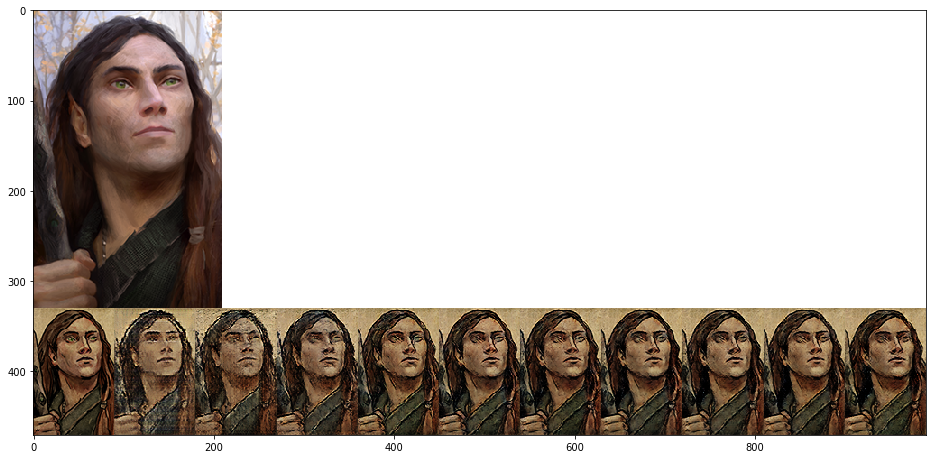

In [29]:
import os
# required to use AMD GPU with keras via plaidml
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.models import load_model
from numpy import load
from numpy import vstack
from numpy import reshape
from matplotlib import pyplot as plt
from numpy.random import randint
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array, load_img
import cv2
import numpy as np

# load model
models = []
for file in os.listdir('trained_models\\'):
    if file.endswith('h5'):
        models.append(file)
        
# path
path = 'data/'
image_list = listdir(path)

portrait_list = [file for file in image_list if file.endswith('lg.png')]
painting_list = [file for file in image_list if file.endswith('convo.png')]
index = randint(0, len(portrait_list))
filename = portrait_list[index]


pixels = load_img(path + filename, target_size=(256,256))
pixels = img_to_array(pixels)
print(filename)
print(pixels.shape)
# # scale from [0,255] to [-1,1]
pixels = (pixels - 127.5) / 127.5
pixels = asarray([pixels])

def resize_pics(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)


combined = cv2.imread(path+painting_list[index])
combined = cv2.cvtColor(combined, cv2.COLOR_RGB2BGR)


for model in models:
    print(model)
    model = load_model('trained_models\\'+model)
    # generate image from source
#     gen_image = model.predict(pixels)
#     gen_image = (gen_image[0] + 1) / 2.0
#     gen_image = resize_pics(gen_image, (90,141))
    gen_image = model.predict(pixels)
    fixed_gen = (gen_image*127.5)+127.5
    fixed_gen = fixed_gen.astype('uint8')
    fixed_gen = cv2.resize(fixed_gen[0], dsize=(90, 141), interpolation=cv2.INTER_CUBIC)
#     fixed_gen = cv2.cvtColor(fixed_gen, cv2.COLOR_RGB2BGR)
    combined = cv2.hconcat([combined, fixed_gen])

portrait = cv2.imread(path+filename)
portrait = cv2.cvtColor(portrait, cv2.COLOR_RGB2BGR)
print(portrait.shape)
print(combined.shape)
large =  cv2.copyMakeBorder(portrait, 
                             0, 
                             0, 
                             0, 
                             combined.shape[1]-portrait.shape[1], 
                             cv2.BORDER_CONSTANT, 
                             value=(255,255,255)
                          )

combined = cv2.vconcat([large, combined])
print('Writing', filename)
    
plt.figure(figsize=(16,8))
plt.imshow(combined)

## Testing model on testing set images

FODWUz.png
(256, 256, 3)
model_001310.h5
model_002620.h5
model_003930.h5
model_005240.h5
model_006550.h5
model_007860.h5
model_009170.h5
model_010480.h5
model_011790.h5
model_013100.h5
(330, 210, 3)
(141, 990, 3)
Writing FODWUz.png


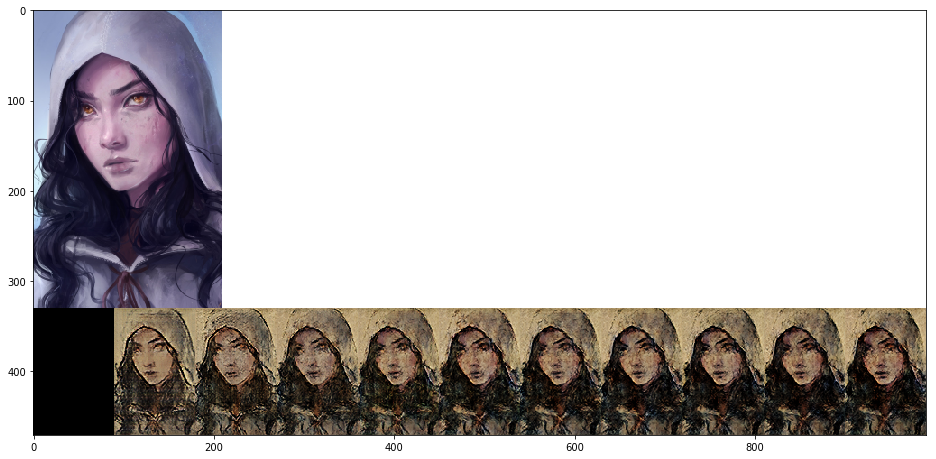

In [32]:
import os
# required to use AMD GPU with keras via plaidml
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.models import load_model
from numpy import load
from numpy import vstack
from numpy import reshape
from matplotlib import pyplot as plt
from numpy.random import randint
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array, load_img
import cv2
import numpy as np

# load model
models = []
for file in os.listdir('trained_models\\'):
    if file.endswith('h5'):
        models.append(file)
        
# TEST path
path = 'test_data/'
test_files = listdir(path)

filename = test_files[randint(0, len(test_files))]

pixels = load_img(path + filename, target_size=(256,256))
pixels = img_to_array(pixels)
print(filename)
print(pixels.shape)
# # scale from [0,255] to [-1,1]
pixels = (pixels - 127.5) / 127.5
pixels = asarray([pixels])

def resize_pics(img, size):
    return cv2.resize(img, dsize=size, interpolation=cv2.INTER_CUBIC)

combined = np.zeros((141,90,3), np.uint8)
for model in models:
    print(model)
    model = load_model('trained_models\\'+model)
    # generate image from source
#     gen_image = model.predict(pixels)
#     gen_image = (gen_image[0] + 1) / 2.0
#     gen_image = resize_pics(gen_image, (90,141))
    gen_image = model.predict(pixels)
    fixed_gen = (gen_image*127.5)+127.5
    fixed_gen = fixed_gen.astype('uint8')
    fixed_gen = cv2.resize(fixed_gen[0], dsize=(90, 141), interpolation=cv2.INTER_CUBIC)
#     fixed_gen = cv2.cvtColor(fixed_gen, cv2.COLOR_RGB2BGR)
    combined = cv2.hconcat([combined, fixed_gen])

portrait = cv2.imread(path+filename)
portrait = cv2.cvtColor(portrait, cv2.COLOR_RGB2BGR)
print(portrait.shape)
print(combined.shape)
large =  cv2.copyMakeBorder(portrait, 
                             0, 
                             0, 
                             0, 
                             combined.shape[1]-portrait.shape[1], 
                             cv2.BORDER_CONSTANT, 
                             value=(255,255,255)
                          )

combined = cv2.vconcat([large, combined])
print('Writing', filename)
    
plt.figure(figsize=(16,8))
plt.imshow(combined)

## Testing model on training set images with a community-made painting version

2044935552_matt_in_lg.png
(256, 256, 3)
test_data_painted/2044935552_matt_in_lg_painted
model_001310.h5
model_002620.h5
model_003930.h5
model_005240.h5
model_006550.h5
model_007860.h5
model_009170.h5
model_010480.h5
model_011790.h5
model_013100.h5
(330, 210, 3)
(141, 990, 3)
Writing 2044935552_matt_in_lg.png


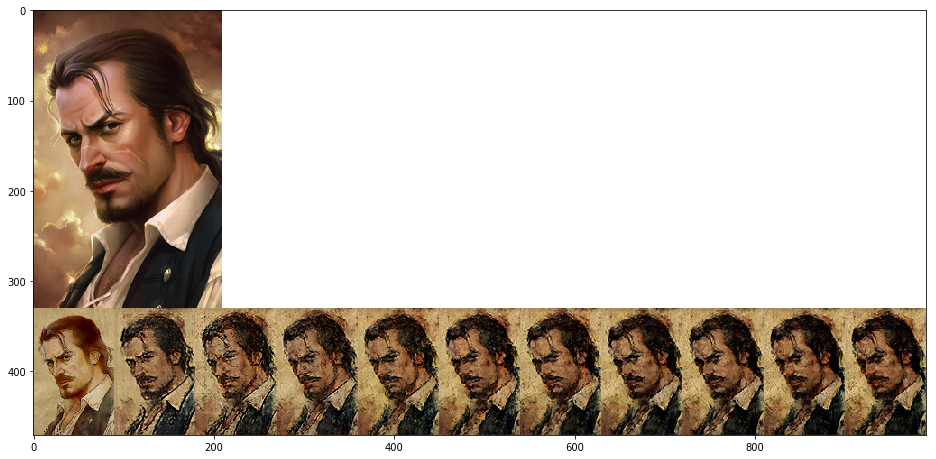

In [33]:
import os
# required to use AMD GPU with keras via plaidml
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
from keras.models import load_model
from numpy import load
from numpy import vstack
from numpy import reshape
from matplotlib import pyplot as plt
from numpy.random import randint
from os import listdir
from numpy import asarray
from keras.preprocessing.image import img_to_array, load_img
import cv2
import numpy as np

# load model
models = []
for file in os.listdir('trained_models\\'):
    if file.endswith('h5'):
        models.append(file)
        
# TEST path
path = 'test_data_painted/'
test_files = listdir(path)

filename = '2044935552_matt_in_lg.png'
pixels = load_img(path + filename, target_size=(256,256))
pixels = img_to_array(pixels)
print(filename)
print(pixels.shape)
# # scale from [0,255] to [-1,1]
pixels = (pixels - 127.5) / 127.5
pixels = asarray([pixels])


combined = cv2.imread(path+filename[:-4]+'_painted.png')
combined = cv2.cvtColor(combined, cv2.COLOR_RGB2BGR)

print(path+filename[:-4]+'_painted')
for model in models:
    print(model)
    model = load_model('trained_models\\'+model)
    gen_image = model.predict(pixels)
    fixed_gen = (gen_image*127.5)+127.5
    fixed_gen = fixed_gen.astype('uint8')
    fixed_gen = cv2.resize(fixed_gen[0], dsize=(90, 141), interpolation=cv2.INTER_CUBIC)
    combined = cv2.hconcat([combined, fixed_gen])

portrait = cv2.imread(path+filename)
portrait = cv2.cvtColor(portrait, cv2.COLOR_RGB2BGR)
print(portrait.shape)
print(combined.shape)
large =  cv2.copyMakeBorder(portrait, 
                             0, 
                             0, 
                             0, 
                             combined.shape[1]-portrait.shape[1], 
                             cv2.BORDER_CONSTANT, 
                             value=(255,255,255))

combined = cv2.vconcat([large, combined])
print('Writing', filename)
    
plt.figure(figsize=(16,8))
plt.imshow(combined)

## Conclusion
* results are great on training set but uneven on testing set... OVERFITTING ALERT
* Next steps...
* Rework GAN to train faster by designing it for 128x128
* Apply methods to reduce overfitting (dropout already implemented)
* Maybe find more data?